### Importing Libraries

In [63]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


**Run these commands to install the packages** 

1. Install the imblearn package to use the SMOTE for oversampling the minority class

    `conda install -c conda-forge imbalanced-learn`

2. Install the XGBoost package to use the XGBClassifier

    `pip install xgboost`

## Workflow

1. Importing the data files and creating a training, validation and test data

2. Exploratory Data Analysis

3. Data Preprocessing and Feature Engineering

4. Baseline Model Building

5. Fitting Models of Selected Features

6. Hyperparameter Tuning

7. Final Evaluations

8. Conclusion

### Importing the data files

##### Folder Structure 

```
    ├── src
    │   ├── data
    │   │   ├── diabetic_data_test.csv
    │   │   ├── diabetic_data_train.csv
    │   │   ├── diabetic_data.csv
    │   │   ├── IDs_mapping.csv
    ├── HemantRattey_DSCI633_project_final.ipynb
```

In [64]:
# Storing the path for all data files
data_folder = 'data' # the data folder stores all the data files
train_filepath = os.path.join(data_folder, 'diabetic_data_train.csv')
test_filepath = os.path.join(data_folder, 'diabetic_data_test.csv')
original_filepath = os.path.join(data_folder, 'diabetic_data.csv')

In [65]:
# Reading the train data
train_df_old = pd.read_csv(train_filepath, index_col = 0)
train_df_old.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
93634,338369606,159605546,AfricanAmerican,Male,[70-80),?,1,23,7,3,...,No,No,No,No,No,No,No,No,No,NO
27698,90739116,83232054,Caucasian,Female,[70-80),[75-100),3,1,1,1,...,No,No,No,No,No,No,No,No,No,NO
17488,64286964,95117913,Caucasian,Male,[60-70),?,3,1,1,4,...,No,No,No,No,No,No,No,Ch,Yes,>30
96510,376610012,136697972,AfricanAmerican,Male,[40-50),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
35774,110557278,2851308,Caucasian,Male,[80-90),?,1,1,6,1,...,No,No,No,No,No,No,No,No,No,NO


It is best practice to keep the test data for final evaluation of the model. That is why creating a validation set is important. Here, I am splitting the training data into 15% of random validation data. The training data is the left over data after removing the validation data.

In [66]:
# Creating validation set and updating the training data
val_df = train_df_old.sample(frac = 0.15, random_state = 633) # Create 15% of validation data from the training data
train_df = train_df_old.drop(val_df.index) # Update training data
print('--------------------- The validation data looks as follows ----------------------------')
display(val_df.head())
print()
print()
print('--------------------- The training data looks as follows ----------------------------')
display(train_df.head())

--------------------- The validation data looks as follows ----------------------------


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
49863,150424464,24402996,AfricanAmerican,Female,[90-100),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
88527,284640060,102785004,Caucasian,Male,[60-70),?,2,3,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,NO
95756,366089528,43748883,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
12976,52190166,1278945,Caucasian,Female,[60-70),?,1,18,7,2,...,No,No,No,No,No,No,No,Ch,Yes,NO
88227,283013022,41004648,AfricanAmerican,Female,[60-70),?,1,11,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO




--------------------- The training data looks as follows ----------------------------


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
93634,338369606,159605546,AfricanAmerican,Male,[70-80),?,1,23,7,3,...,No,No,No,No,No,No,No,No,No,NO
27698,90739116,83232054,Caucasian,Female,[70-80),[75-100),3,1,1,1,...,No,No,No,No,No,No,No,No,No,NO
17488,64286964,95117913,Caucasian,Male,[60-70),?,3,1,1,4,...,No,No,No,No,No,No,No,Ch,Yes,>30
96510,376610012,136697972,AfricanAmerican,Male,[40-50),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
74984,224162346,109195155,Caucasian,Male,[80-90),?,1,6,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [67]:
# Reading the test data
test_df = pd.read_csv(test_filepath, index_col = 0)
print('--------------------- THe test data looks as follows ----------------------------')
print()
test_df.head()

--------------------- THe test data looks as follows ----------------------------



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
77011,233192070,110179728,Caucasian,Female,[80-90),?,1,3,7,11,...,No,No,No,No,No,No,No,Ch,Yes,>30
95048,356145692,40743441,Caucasian,Female,[30-40),?,1,1,7,5,...,No,Up,No,No,No,No,No,Ch,Yes,>30
29619,96590916,235017,AfricanAmerican,Male,[70-80),?,2,1,1,1,...,No,Steady,No,No,No,No,No,No,Yes,NO
85031,268888392,70368660,Caucasian,Male,[70-80),?,3,6,1,3,...,No,No,No,No,No,No,No,No,No,NO
13003,52253142,19835496,AfricanAmerican,Female,[70-80),?,3,18,1,6,...,No,No,No,No,No,No,No,Ch,Yes,NO


In [68]:
# Create a copy of the data as a checkpoint
original_df = pd.read_csv(original_filepath)
diabetic_df = original_df.copy()

## Exploratory Data Analysis

In [69]:
# Looking at the class variable -> readmitted
def get_bar_plot_readmitted(df, attribute):
    '''
    The get_bar_plot_readmitted function takes a dataframe and attribute name as input and calculates the class distribution in that attribute as well
    as plots the barplot for that attribute. It first prints the plot for values as given in the dataset. It also converts the values in the class variable 
    to represent a binary classification problem and then prints the bar plot for the same attribute.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    attribute (String) : A string representing the attribute name
    '''
    new_df = df.copy() # Creates a new copy just to be safe

    # Change the values in the readmitted column so that they appear nicely in the plot
    new_df[attribute + '_1'] = new_df[attribute].replace({'NO' : 'No readmission', '>30' : 'Readmission after 30 days', '<30' : 'Readmission within 30 days'})

    # Plotting bar plot for the attribute
    plt.figure(figsize = (9, 7)) 
    ax = sns.countplot(data = new_df, x = attribute + '_1')
    sns.despine(top = True) # Remove the axes spine lines 
    ax.set(xlabel = 'Readmission', ylabel = "Number of encouters", title = "Frequency Distribution for Readmission \n (Before converting to Binary)");
    ax.tick_params(axis = 'x', which = 'major', pad = 3)

    # Adding count values to the bar plots
    for container in ax.containers:
        ax.bar_label(container)
    
    # Change the values in the readmitted column so that it now represents a binary attribute
    new_df[attribute + '_2'] = new_df[attribute].replace({'NO' : 'No readmission or after 30 days', '>30' : 'No readmission or after 30 days', '<30' : 'Readmission within 30 days'})
    plt.figure(figsize = (9, 9)) 
    ax1 = sns.countplot(data = new_df, x = attribute + '_2')
    sns.despine(top = True) # Remove the axes spine lines 
    ax1.set(xlabel = 'Readmission', ylabel = "Number of encouters", title = "Frequency Distribution for Readmission \n (After converting to Binary)");
    ax1.tick_params(axis = 'x', which = 'major', pad = 3) # Add padding between xlabel and xticklabels

    # Adding count values to the bar plots
    for container in ax1.containers:
        ax1.bar_label(container)

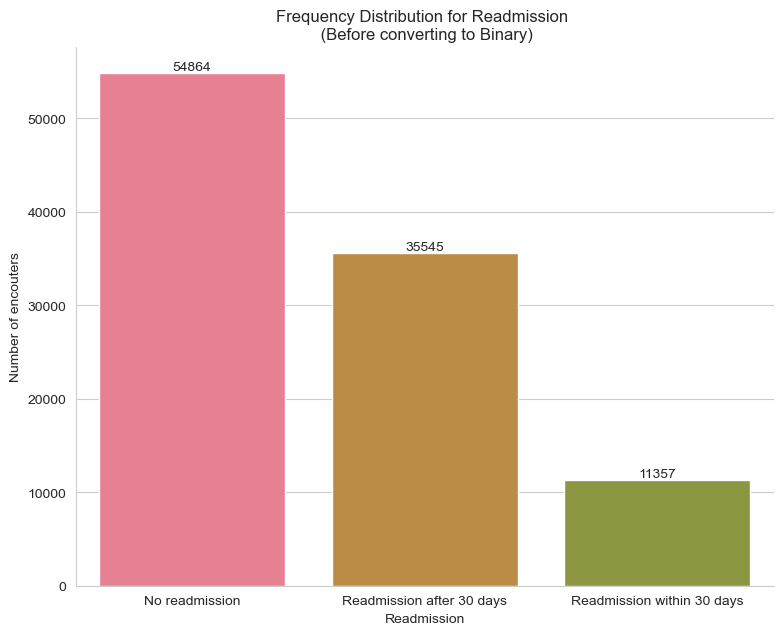

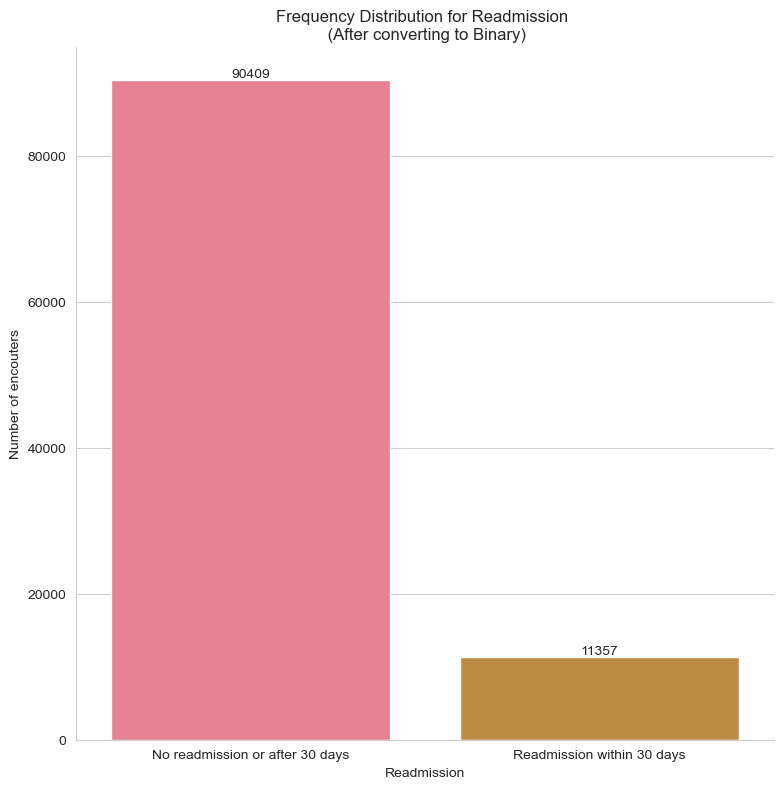

In [70]:
sns.set_style('whitegrid') # Set the plot style
sns.set_palette("husl", 8) # Set the plot color palette

# Create a bar plot for the class variable readmitted
get_bar_plot_readmitted(diabetic_df, 'readmitted')

For the class variable `readmitted`, there are 3 possible scenarios - **NO** (No readmission), **>30** (Readmission occurred after 30 days) and **<30** (Readmission occurred within 30 days). We can clearly see that encouters with no readmission happens more than 50% of all the encouters. Since, we have to treat the problem as a binary variable, our scope is to look at the case where readmission happened within 30 days. We will treat readmission post 30 days as no readmission. Hence, the encouters where no readmission happens increases.

In [71]:
def get_independent_versus_target_plot(df, attribute):
    '''
    The get_independent_versus_target_plot function takes a dataframe and attribute name as input and 
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    attribute (String) : A string representing the attribute name
    '''
    
    new_df = df.copy() # Creates a new copy just to be safe

    # Convert readmitted column to represent a binary classification problem
    new_df['readmitted'] = new_df['readmitted'].replace({'NO' : 0, '>30' : 0, '<30' : 1})
    new_df[attribute] = new_df[attribute].replace({'?' : 'Unknown/Invalid'}) # Only for plotting, ? will be dropped while cleaning data
    
    # Plotting bar plot for the attribute
    plt.figure(figsize = (10, 8)) 
    ax = sns.countplot(data = new_df, x = attribute)
    sns.despine(top = True) # Remove the axes spine lines 
    ax.set(xlabel = '\n' + attribute.title(), ylabel = "Frequency", title = "Frequency Distribution for " + attribute.title());
    ax.tick_params(axis = 'x', which = 'major', pad = 3)

    # Adding count values to the bar plots 
    for container in ax.containers:
        ax.bar_label(container)

    # Plotting the bar plot for the attribute grouped by the readmitted class variable    
    plt.figure(figsize = (10, 12))
    ax1 = sns.countplot(data = new_df, x = attribute, hue = 'readmitted')
    sns.despine(top = True) # Remove the axes spine lines 
    ax1.set(xlabel = '\n' + attribute.title(), ylabel = "Frequency", title = "Frequency Distribution for " + attribute.title() + ' vs Readmitted');
    ax1.tick_params(axis = 'x', which = 'major', pad = 3)

    # Adding count values to the bar plots
    for container in ax1.containers:
        ax1.bar_label(container)

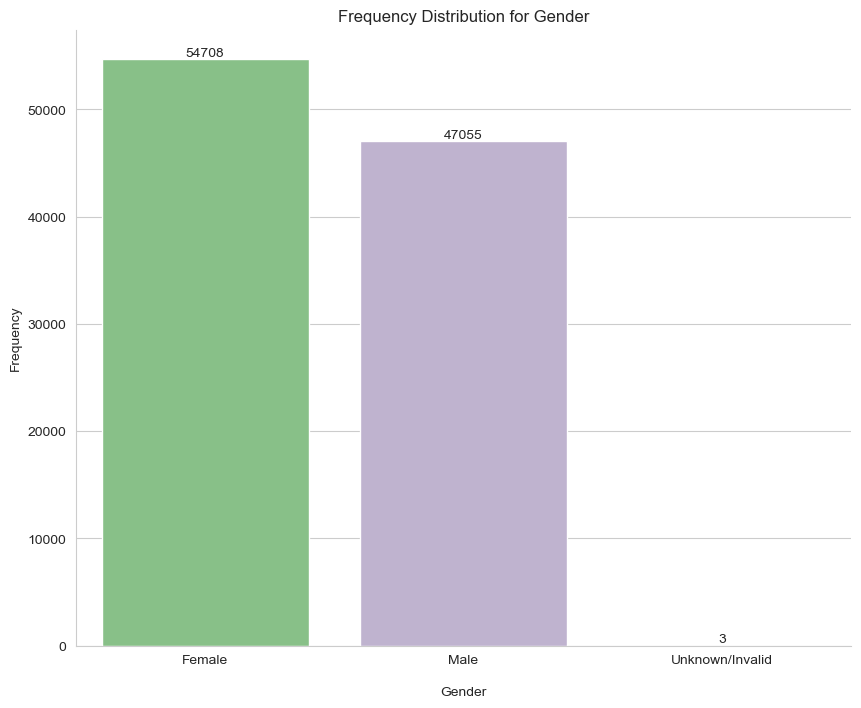

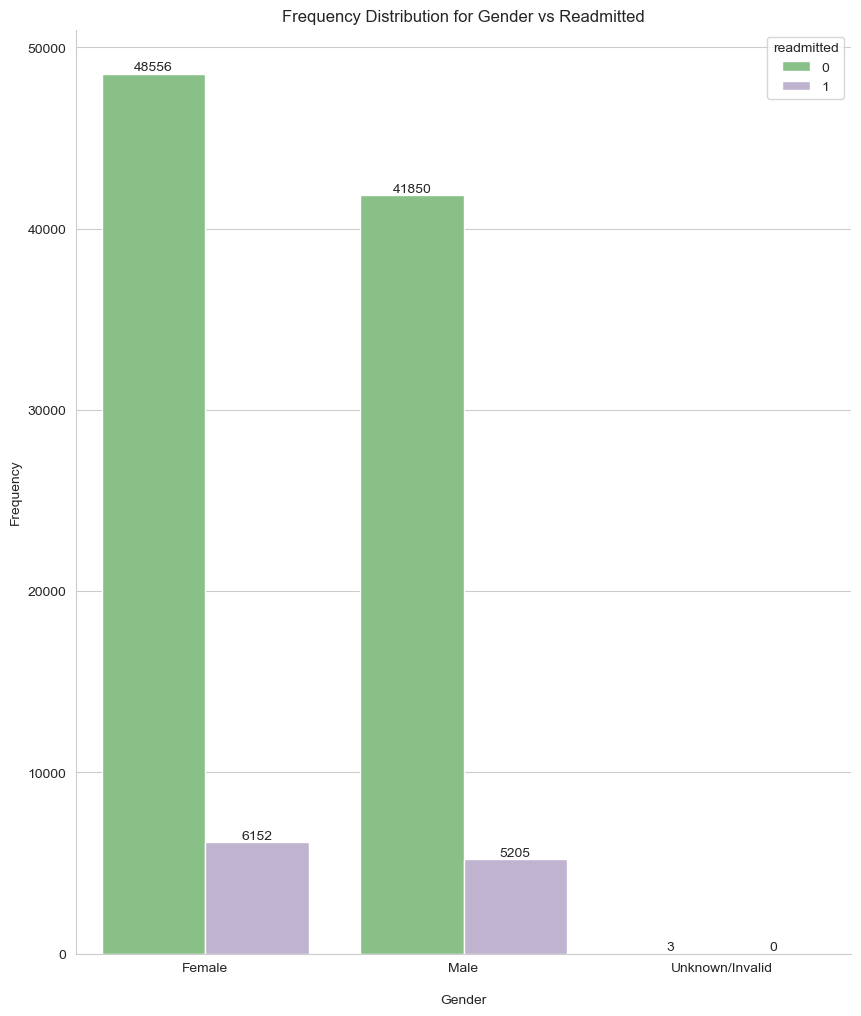

In [72]:
sns.set_palette('Accent')

# Creating a bar plot for the gender vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'gender')

The genders are more or less equally balanced with only a ~7000 difference between *Female* and *Male* patients respectively. Additionally, the genders grouped by readmission are also more or less equally balanced. There are 3 Unknown/Invalid genders which will be dropped later in the cleaning process.

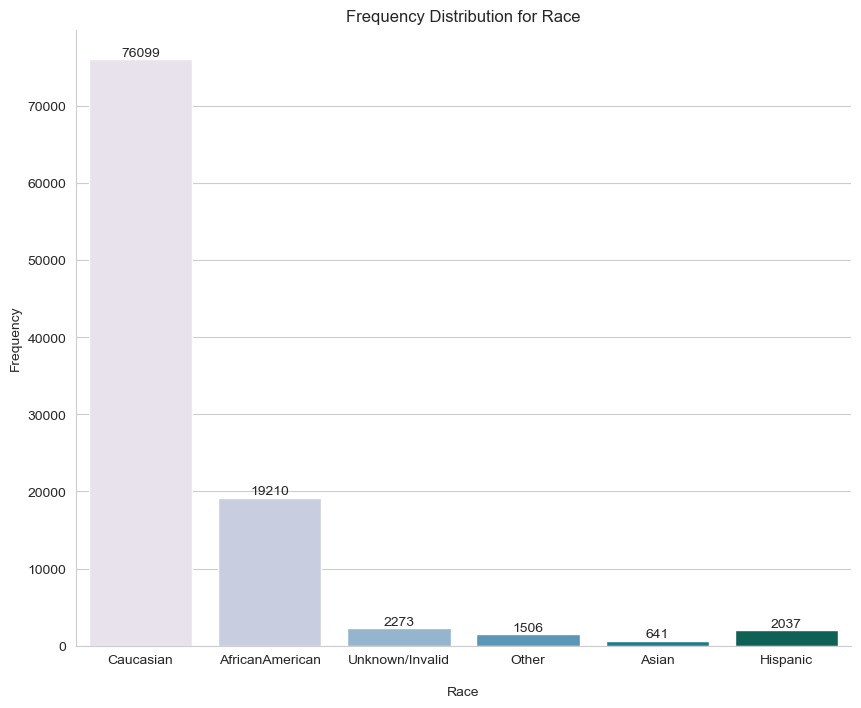

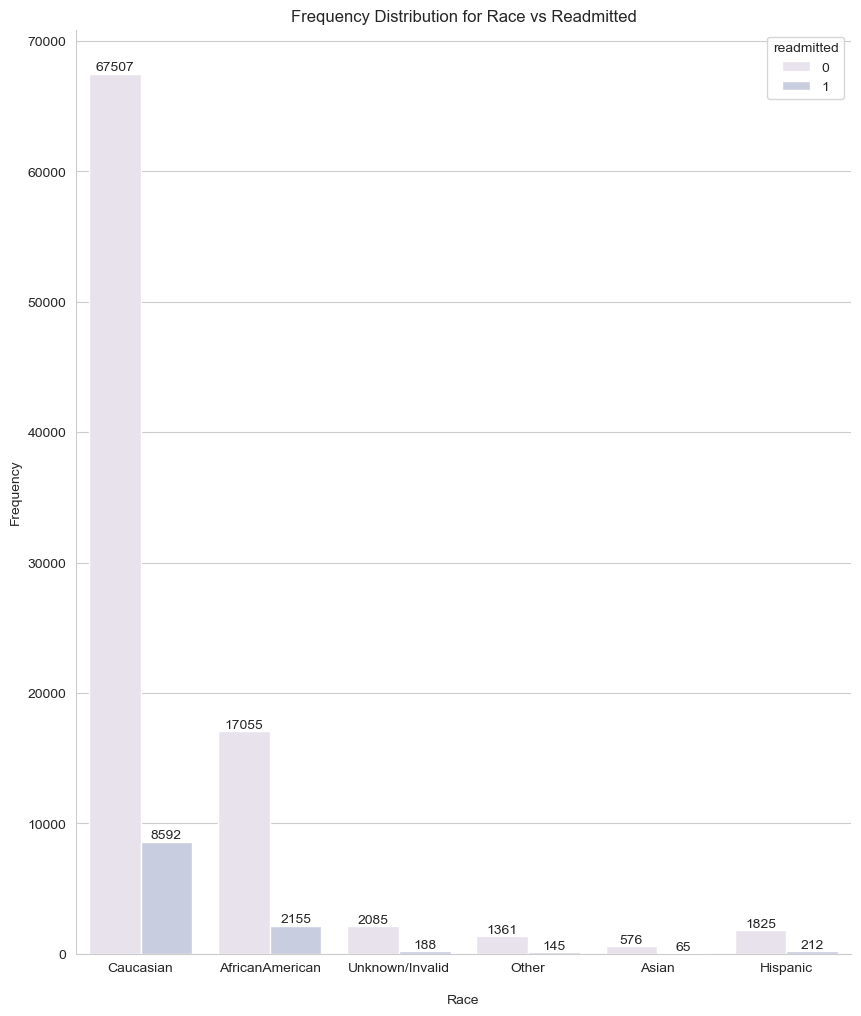

In [73]:
sns.set_palette('PuBuGn')

# Creating a bar plot for the race vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'race')

The countplots for `race` clearly represent that a majority of patients are *Caucasian* which is nearly 75% or three-fourths of all the data. This could be because the study was conducted in a caucasian dominated region. Another explanation could be the eating and lifestyle habits of caucasians which might result in diabetic complications. One interesting insight which can be drawn is that out of ~76,000 encouters, only 8592 resulted in readmission which is only about 11%. 

Another insight that can be drawn is that *Asians*, *Hispanics* and *Others* are very low in number. Hence, we can maybe group all of them into 1 category - **Other**.

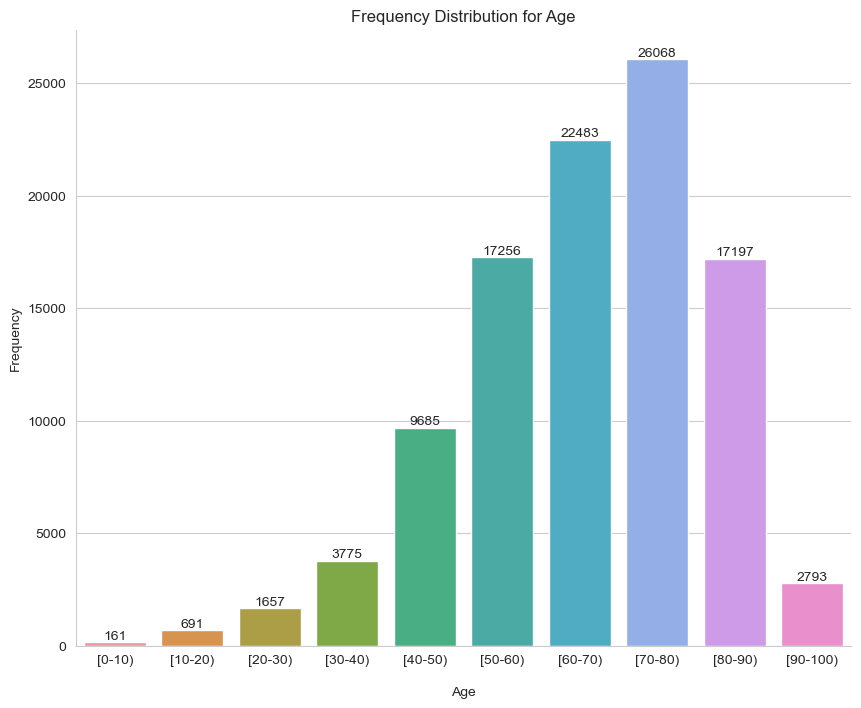

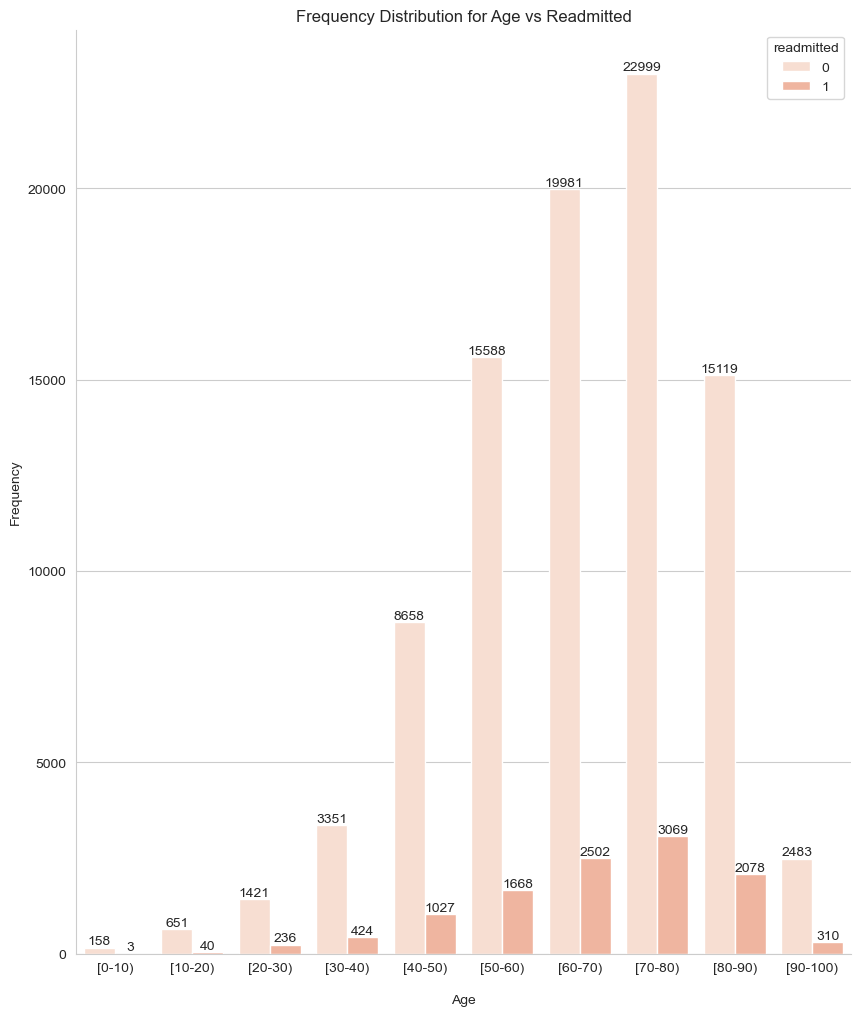

In [74]:
sns.set_palette('Reds')

# Creating a bar plot for the age vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'age')

While looking at the count plots for `age` column, one insight that can be drawn is that a lot of the patients are of older age. This is in line with the fact that people in old age tend to experience diabetes as compared to people younger than them. This is true for readmission of patients as well. The patients readmitted the most are of older age group.

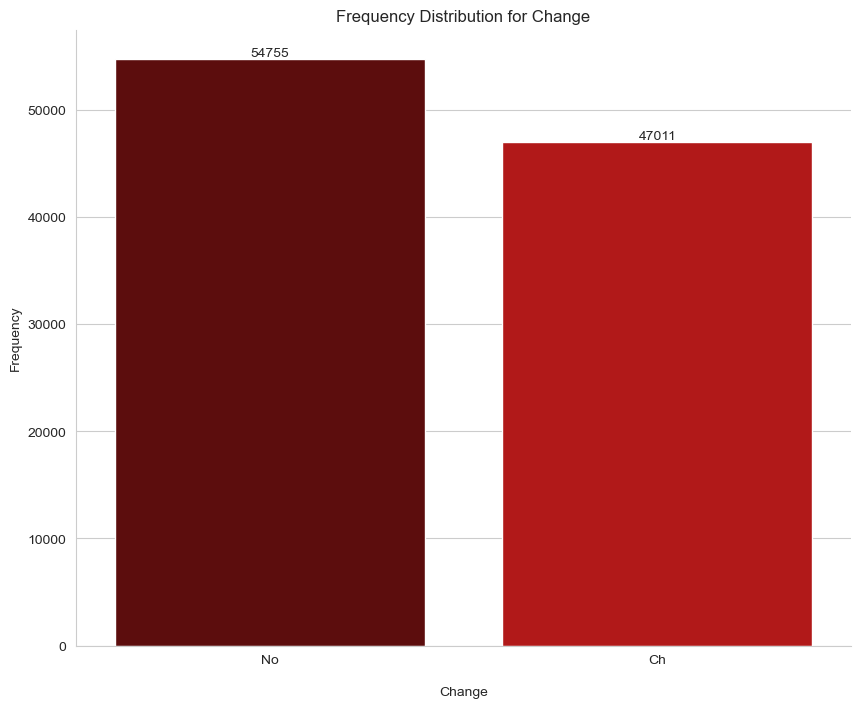

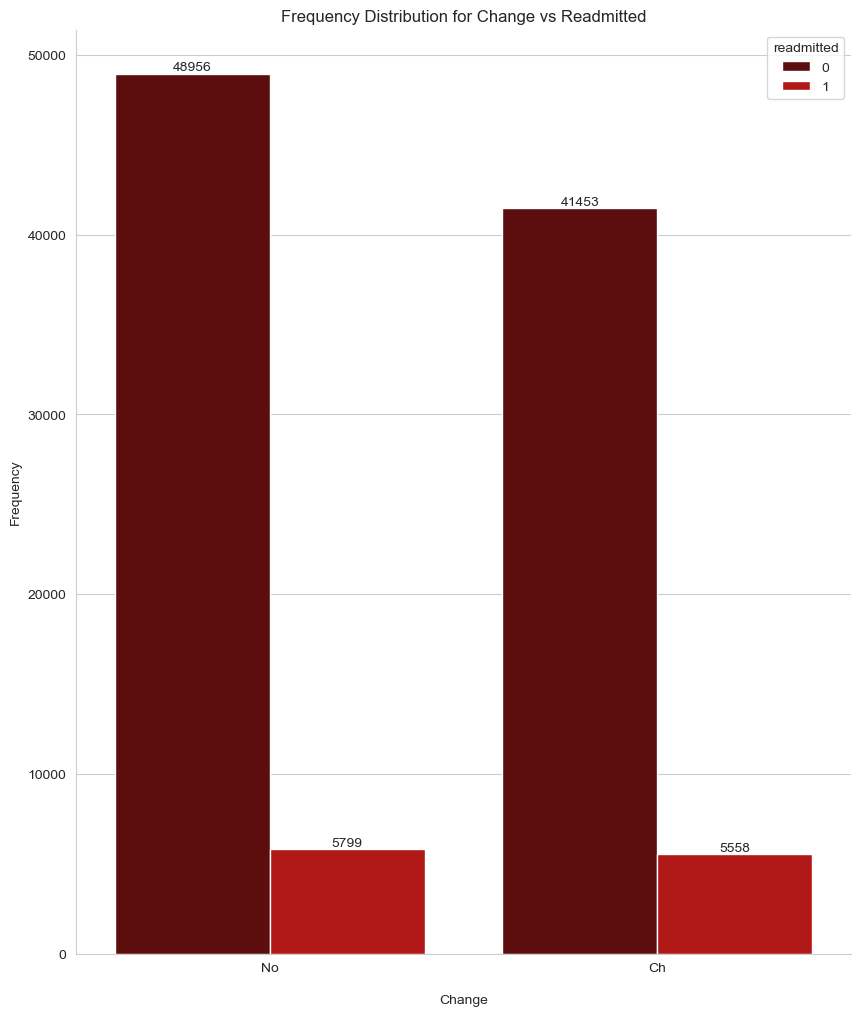

In [75]:
sns.set_palette('hot')

# Creating a bar plot for the change vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'change')

Looking at the `change` column, we can see that there aren't any particular insights that differentiate the values too much. Both *No change* and *change* are equally distributed and same goes for readmission.

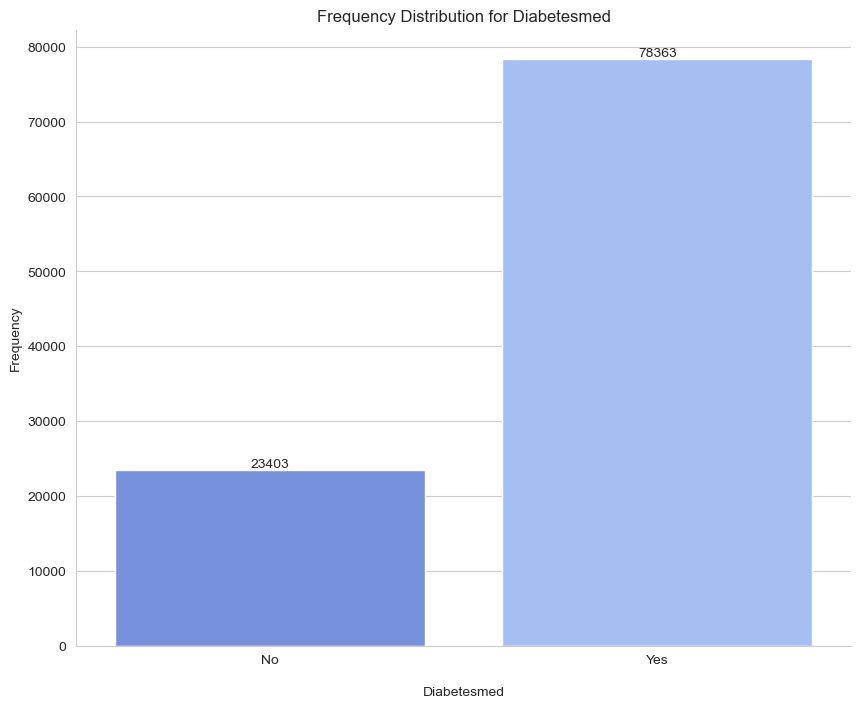

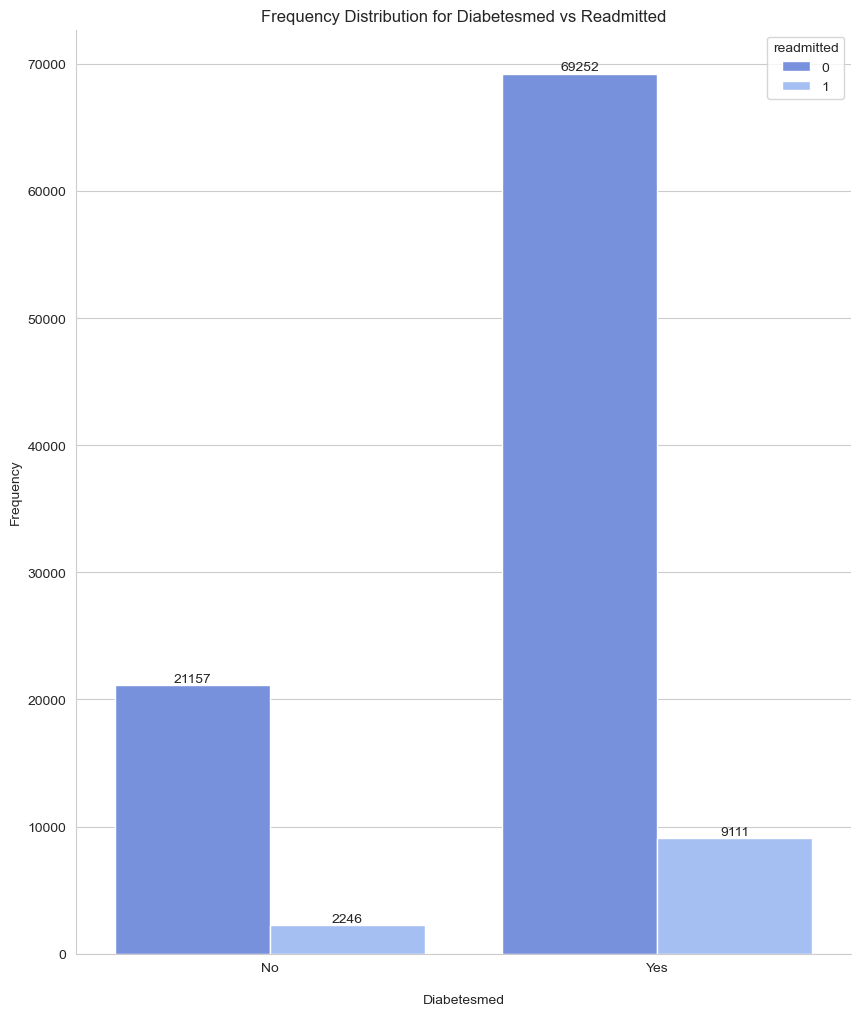

In [76]:
sns.set_palette('coolwarm')

# Creating a bar plot for the diabetesMed vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'diabetesMed')

By looking at the `diabetedMed` column, we can see that patients that were prescribed a diabetes medication during the encouter dominates over those who weren't prescribed any medication. Additionally, patients that weren't described a medication were readmitted lesser than the others. This might be because they overcame diabetes or had their sugar levels in control. Or, maybe the patients were just curious if they had diabetes or not and the doctor diagnosed them as not having diabetes hence they didn't get admitted.

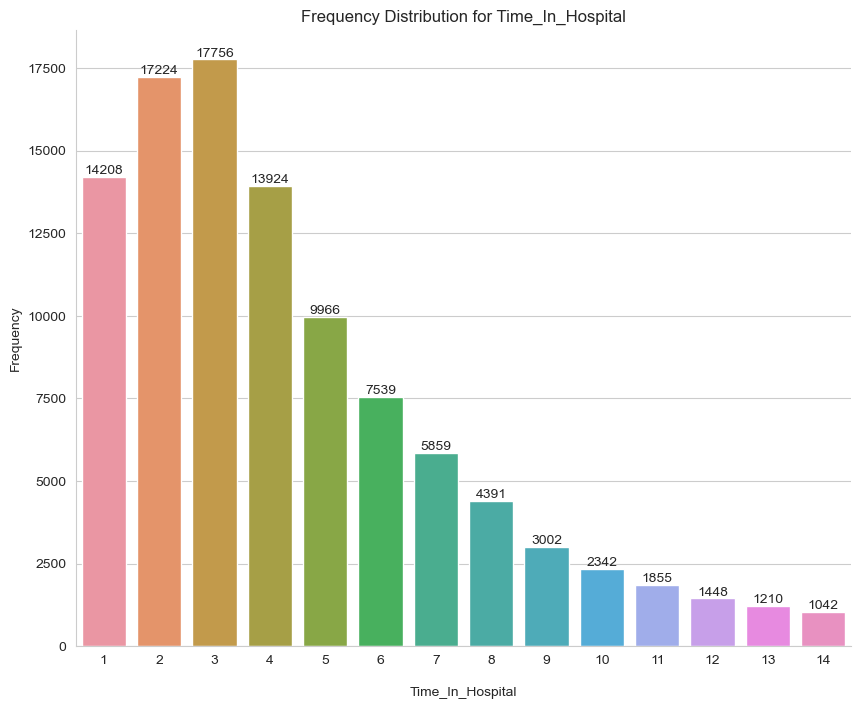

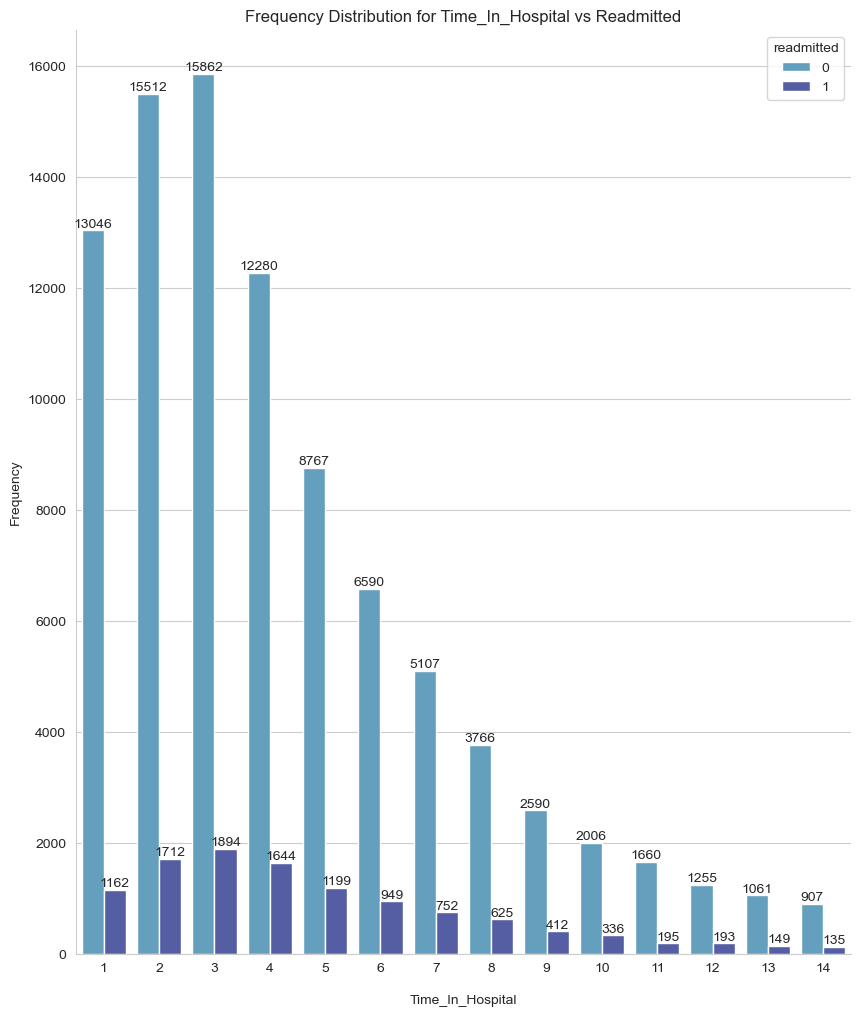

In [77]:
sns.set_palette('icefire')

# Creating a bar plot for the time_in_hospital vs readmitted column
get_independent_versus_target_plot(diabetic_df, 'time_in_hospital')

By looking at the plots for `time_in_hospital` feature, we can conclude that a lot of people spent 1-4 days in the hospital. This is because hospitals need to do primary, secondary and third level of diagnoses and need to perform a lot of lab tests. Thus, patients are admitted in the hospital for multiple days. Also, it is not common for diabetic patients to spend more than 10 days until and unless something is serious.

In [78]:
def get_histogram_plot(df, attribute):
    '''
    The get_histogram_plot function takes a dataframe and attribute name as input and plots the histogram plot for the 
    attribute passed as the parameter.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    attribute (String) : A string representing the attribute name
    '''
    new_df = df.copy() # Creates a copy just to be safe

    # Plotting histogram plot for the attribute
    plt.figure(figsize = (12, 8)) 
    ax = sns.histplot(data = new_df, x = attribute, kde = True)

    # Drawing the average line
    plt.axvline(x = df[attribute].mean(), color = 'red', ls = '--', lw = 2.5)
    
    sns.despine(top = True) # Remove the axes spine lines 
    ax.set(xlabel = '\n' + attribute.title(), ylabel = "Frequency", title = "Frequency Distribution for " + attribute.title());
    ax.tick_params(axis = 'x', which = 'major', pad = 3)

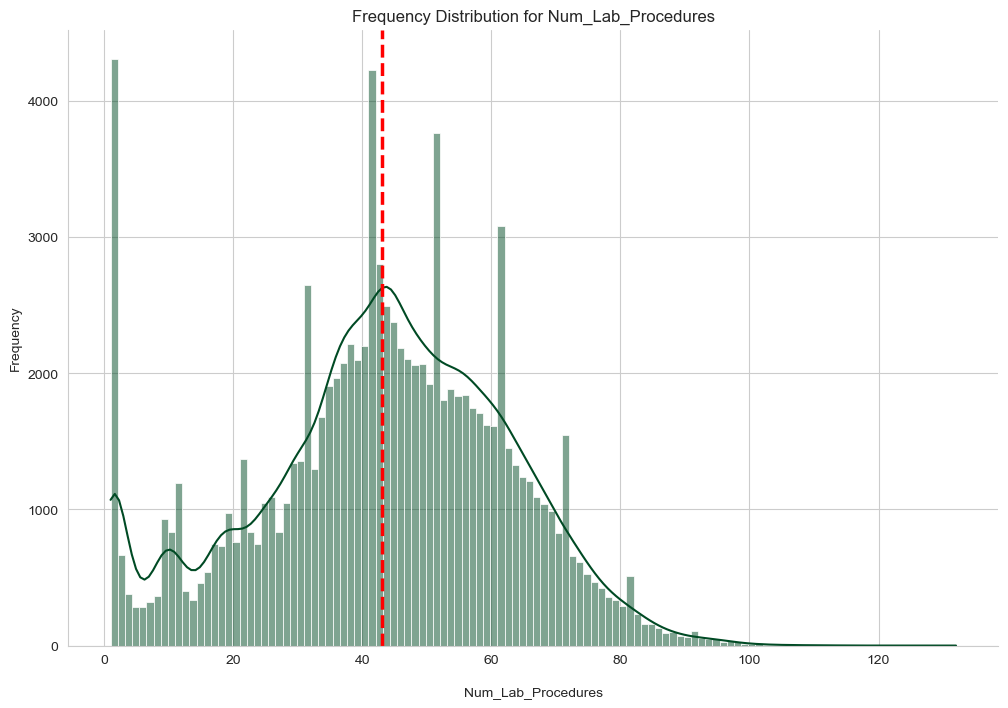

In [79]:
sns.set_palette('ocean')

# Creating a histogram plot for num_lab_procedures
get_histogram_plot(diabetic_df, 'num_lab_procedures')

By looking at the histogram plot for `num_lab_procedures`, we can see that on average around 43 lab procedures are conducted during each encouter. This can be matched with the analysis from the `time_in_hospital` plots. Since, there are more than 40 procedures conducted on average, the length of stay in hospital will also be more.

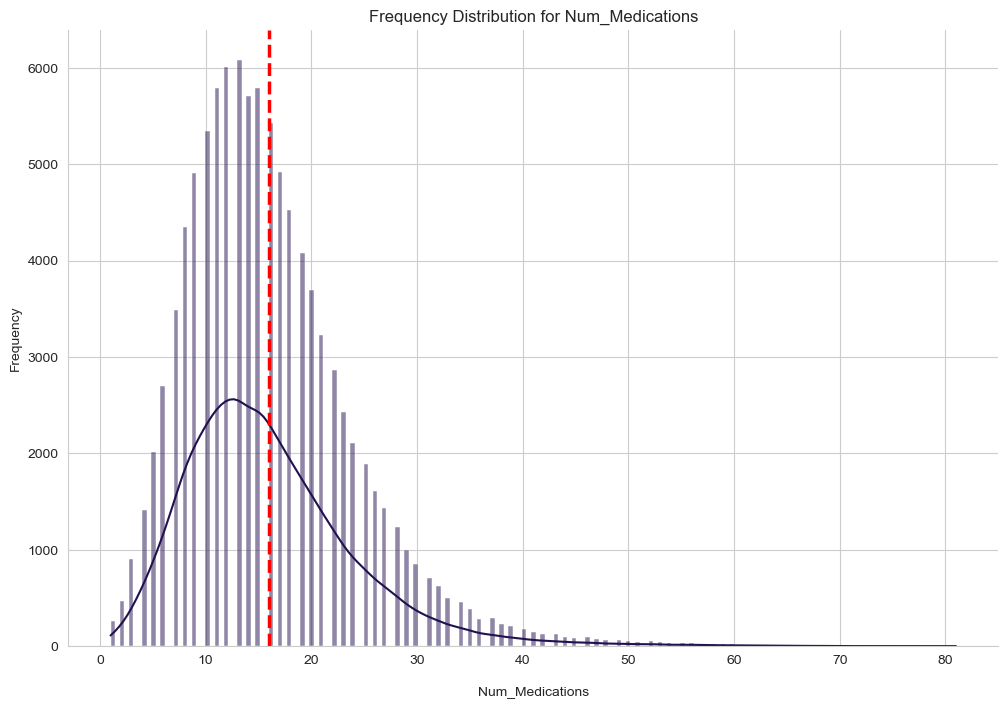

In [80]:
sns.set_palette('magma')

# Creating a histogram plot for num_medications
get_histogram_plot(diabetic_df, 'num_medications')

We can clearly see that during each encouter, the doctors tend to give a certain number of medications to the patients. On average, the patients are given 16 medications in each encouter.

## Data Preprocessing and Feature Engineering

In [81]:
print('There are total', len(diabetic_df.columns), 'features in the dataset.')

There are total 50 features in the dataset.


In [82]:
def cleaning_nulls_removing_columns(df):
    '''
    The cleaning_nulls_removing_columns function takes a dataframe as input parameter and drops the unwanted columns and rows. For instance, 
    the column patient_nbr is dropped and rows where '?' is present is marked as NaN which are then dropped ahead. Additionally, the function
    drops those columns that have more than 25% of missing data. Also, the rows where gender is 'Unknown/Invalid' are also dropped. Finally,
    the function checks the number of unique values in all the columns and drops those where either all the rows have the same value, or drops
    those where number of unique values are too high which won't be of any help in the analysis.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that is cleaned
    '''
    new_df = df.copy()

    # print(new_df.isnull().sum() * 100 / len(new_df)) # Print the null count
    new_df.drop(columns = ['patient_nbr'], inplace = True) # Drop the patient number column as it will have a lot of unique values
   
    # for col in new_df.columns:
    #     print(col + " ------> " + str(new_df[new_df[col] == '?'].shape[0]))

    # Replacing ? in the data with NaN values
    new_df.replace({'?' : np.nan}, inplace = True)

    # Finding out percentage of missing values for each column
    percent_missing = round(new_df.isnull().sum() * 100 / len(new_df), 2)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing}).reset_index().rename(columns = {'index' : 'column_names'})

    # Drop columns where more than 25% of the values are missing
    cols_to_drop = missing_value_df.loc[missing_value_df['percent_missing'] > 25, 'column_names'].values.tolist()
    new_df = new_df.drop(columns = [col for col in new_df if col in cols_to_drop])

    # Drop rows where gender is Unknown/Invalid
    new_df = new_df[new_df['gender'] != 'Unknown/Invalid']

    # Check for missing values and drop if very low percentage
    # print(round(new_df.isnull().sum() * 100 / len(new_df), 2))
    new_df.dropna(inplace = True)

    # Look at unique values for each column and drop those columns if there are too many unique values, and drop those columns where there is only 1 unique value
    # print(new_df.nunique().sort_values(ascending = False))
    
    new_df.drop(columns = ['encounter_id', 'metformin-rosiglitazone', 'examide', 'citoglipton'], inplace = True)

    return new_df

In [83]:
diabetic_df = cleaning_nulls_removing_columns(diabetic_df)

Since, the columns **weight**, **payer_code** and **medical_specialty** have a lot of missing values, they can be dropped. In general, if a column has more than 25% of missing values, it can be dropped as it would not lead to any useful predictions.

Since, there are only 3 rows which has Unknown/Invalid value for gender, it can be dropped.

Now, since the columns **race**, **diag_1**, **diag_2** and **diag_3** have a small percentage of missing values, these rows can be dropped as it won't affect the outcome too much. There are 3711 missing values out of 101763 values, hence dropping them doesn't affect our analysis too much.

By looking at the number of unique values for each column, we can drop the columns that satisfy the following conditions : 

- If the column has number of unique values equal to the length of the dataframe, then it is not a useful feature as all records will be unique and no prediction can be made. For example, the column **encounter_id** has 98053 unique values which is equal to the length of the dataframe. Hence, it can be dropped.

- Additionally, if a column only has 1 unique value i.e. all the records in the dataset have only 1 value, then it is not a useful feature as every record will have the same value which is not helpful for prediction. For example, columns **metformin-rosiglitazone**, **examide** and **citoglipton** have only 1 unique value and hence they can be dropped.

Admission Type ID

| admission_type_id | Description      |
|-------------------|------------------|
| 1                 | Emergency        |
| 2                 | Urgent           |
| 3                 | Elective         |
| 4                 | Newborn          |
| 5                 | Not Available    |
| 6                 | NULL             |
| 7                 | Trauma Center    |
| 8                 | Not Mapped       |

In the **admission_type_id** column, we can map 6 and 8 as 5 values and these can be later dropped if they don't affect our data distribution too much as they won't be of any significance in our prediction. Similarly, grouping `Trauma Center` and `Urgent` as `Emergency` makes sense and decreases the number of features as well.

In [84]:
def cleaning_admission_type_id(df):
    '''
    The cleaning_admission_type_id function takes a dataframe as input parameter and groups the distinct ids together based
    on their general medical meaning and significance.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that has the decomposed mapping
    '''
    new_df = df.copy()
    # Create a dictionary mapping for Not Available
    na_rows = {6 : 5, 8 : 5}

    # Create a dictionary mapping for Emergency
    emergency_rows = {2 : 1, 7 : 1}

    # Update the ids and group them together based on the dictionary mappings created
    new_df['admission_type_id'] = new_df['admission_type_id'].replace(na_rows)
    new_df['admission_type_id'] = new_df['admission_type_id'].replace(emergency_rows)
    
    return new_df

diabetic_df_cleaned_admissions = cleaning_admission_type_id(diabetic_df)

discharge disposition id

| discharge\_disposition\_id | description                                                                                               |
| -------------------------- | --------------------------------------------------------------------------------------------------------- |
| 1                          | Discharged to home                                                                                        |
| 2                          | Discharged/transferred to another short term hospital                                                     |
| 3                          | Discharged/transferred to SNF                                                                             |
| 4                          | Discharged/transferred to ICF                                                                             |
| 5                          | Discharged/transferred to another type of inpatient care institution                                      |
| 6                          | Discharged/transferred to home with home health service                                                   |
| 7                          | Left AMA                                                                                                  |
| 8                          | Discharged/transferred to home under care of Home IV provider                                             |
| 9                          | Admitted as an inpatient to this hospital                                                                 |
| 10                         | Neonate discharged to another hospital for neonatal aftercare                                             |
| 11                         | Expired                                                                                                   |
| 12                         | Still patient or expected to return for outpatient services                                               |
| 13                         | Hospice / home                                                                                            |
| 14                         | Hospice / medical facility                                                                                |
| 15                         | Discharged/transferred within this institution to Medicare approved swing bed                             |
| 16                         | Discharged/transferred/referred another institution for outpatient services                               |
| 17                         | Discharged/transferred/referred to this institution for outpatient services                               |
| 18                         | NULL                                                                                                      |
| 19                         | Expired at home. Medicaid only, hospice.                                                                  |
| 20                         | Expired in a medical facility. Medicaid only, hospice.                                                    |
| 21                         | Expired, place unknown. Medicaid only, hospice.                                                           |
| 22                         | Discharged/transferred to another rehab fac including rehab units of a hospital .                         |
| 23                         | Discharged/transferred to a long term care hospital.                                                      |
| 24                         | Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.   |
| 25                         | Not Mapped                                                                                                |
| 26                         | Unknown/Invalid                                                                                           |
| 30                         | Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere                   |
| 27                         | Discharged/transferred to a federal health care facility.                                                 |
| 28                         | Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital |
| 29                         | Discharged/transferred to a Critical Access Hospital (CAH).                                               |

Similar to the preprocessing done for the *admission_type_id*, we can go through the data dictionary for **discharge_disposition_id** column and see that for ids 18, 25 and 26, we can map it to NaN values and then drop them if they won't affect the data distribution too much.

Additionally, the people who have expired can be dropped as their probability of readmission will be zero.

Also, if we look closely, a lot of the ids can be combined into 1 such as id 13 can be mapped to id 1 as it represents discharged to home. Another example could be that ids 3, 4 and 5 can also be mapped to 2 since all of them represent a medical facility. All these replacements will be done using a dictionary in the function written below.

In [85]:
def cleaning_discharge_disposition_id(df):
    '''
    The cleaning_discharge_disposition_id function takes a dataframe as input parameter and groups the distinct ids together based
    on their general medical meaning and significance.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that has the decomposed mapping
    '''
    new_df = df.copy()
    # Create a dictionary mapping for Not Available 
    na_rows = {25 : 18, 26 : 18}

    # Create a dictionary mapping for Discharged to Home 
    discharged_to_home = {6 : 1, 7 : 1, 8 : 1, 13 : 1}

    # Create a dictionary mapping for Discharged to a Medical Facility
    discharged_to_medical_facility = {3 : 2, 4 : 2, 5 : 2, 10 : 2, 14 : 2, 16 : 2, 22 : 2, 24 : 2, 30 : 2, 28 : 2, 29 : 2, 27 : 2, 23 : 2}

    # Create a dictionary mapping for Expired
    expired = {19 : 11, 20 : 11, 21 : 11}

    # Create a dictionary mapping for currently admitted patients
    admitted_patient = {12 : 9, 15 : 9, 17 : 9}

    # Update the ids and group them together based on the dictionary mappings created
    new_df['discharge_disposition_id'] = new_df['discharge_disposition_id'].replace(na_rows)
    new_df['discharge_disposition_id'] = new_df['discharge_disposition_id'].replace(discharged_to_home)
    new_df['discharge_disposition_id'] = new_df['discharge_disposition_id'].replace(discharged_to_medical_facility)
    new_df['discharge_disposition_id'] = new_df['discharge_disposition_id'].replace(expired)
    new_df['discharge_disposition_id'] = new_df['discharge_disposition_id'].replace(admitted_patient)

    # Drop expired as readmission of them will be 0
    new_df = new_df[new_df['discharge_disposition_id'] != 11]
    
    return new_df

diabetic_df_cleaned_admissions_discharge = cleaning_discharge_disposition_id(diabetic_df_cleaned_admissions)

admission_source_id

| admission\_source\_id | description                                               |
| --------------------- | --------------------------------------------------------- |
| 1                     | Physician Referral                                        |
| 2                     | Clinic Referral                                           |
| 3                     | HMO Referral                                              |
| 4                     | Transfer from a hospital                                  |
| 5                     | Transfer from a Skilled Nursing Facility (SNF)            |
| 6                     | Transfer from another health care facility                |
| 7                     | Emergency Room                                            |
| 8                     | Court/Law Enforcement                                     |
| 9                     | Not Available                                             |
| 10                    | Transfer from critial access hospital                     |
| 11                    | Normal Delivery                                           |
| 12                    | Premature Delivery                                        |
| 13                    | Sick Baby                                                 |
| 14                    | Extramural Birth                                          |
| 15                    | Not Available                                             |
| 17                    | NULL                                                      |
| 18                    | Transfer From Another Home Health Agency                  |
| 19                    | Readmission to Same Home Health Agency                    |
| 20                    | Not Mapped                                                |
| 21                    | Unknown/Invalid                                           |
| 22                    | Transfer from hospital inpt/same fac reslt in a sep claim |
| 23                    | Born inside this hospital                                 |
| 24                    | Born outside this hospital                                |
| 25                    | Transfer from Ambulatory Surgery Center                   |
| 26                    | Transfer from Hospice                                     |

Similar to the approach taken for the *admission_type_id* and *discharge_disposition_id* columns, we can again combine the groups here. Also, since there are only 5 values related to child birth, I'm gonna drop them.

In [86]:
def cleaning_admission_source_id(df):
    '''
    The cleaning_admission_source_id function takes a dataframe as input parameter and groups the distinct ids together based
    on their general medical meaning and significance.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that has the decomposed mapping
    '''
    new_df = df.copy()
    # Create a dictionary mapping for Not Available
    na_rows = {9 : 17, 20 : 17, 21 : 17}

    # Create a dictionary mapping for Referred
    referral = {2 : 1, 3 : 1}

    # Create a dictionary mapping for Transferred
    transfer = {5 : 4, 6 : 4, 18 : 4, 19 : 4, 25 : 4, 26 : 4, 22 : 4}

    # Create a dictionary mapping for Emergency
    emergency = {10 : 7}

    # Update the ids and group them together based on the dictionary mappings created
    new_df['admission_source_id'] = new_df['admission_source_id'].replace(na_rows)
    new_df['admission_source_id'] = new_df['admission_source_id'].replace(referral)
    new_df['admission_source_id'] = new_df['admission_source_id'].replace(transfer)
    new_df['admission_source_id'] = new_df['admission_source_id'].replace(emergency)

    # Drop the rows which correspond to a infant delivery
    new_df = new_df.loc[~new_df['admission_source_id'].isin([11, 12, 13, 14])]

    return new_df

diabetic_df_cleaned_mapping = cleaning_admission_source_id(diabetic_df_cleaned_admissions_discharge)

We can see that for majority of the encounters, the medication was either not given or the dosage was kept steady. Rarely do we see any change in dosage.

According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8077030/, if there is a change in medication, it can lead to lesser readmissions. Hence, we can possibly check the medication changes for each patient.


In [87]:
def cleaning_medications_features(df, col_list):
    '''
    The cleaning_medications_features function takes a dataframe and a column list as input and implements an approach to clean
    the approximately 20 medication dosage change features. The approach taken here is that for each encouter, the function will
    calculate the number of dosage changes across the 20 or so medications. If the dosage was 'No' or 'Steady', then it is marked as
    0 otherwise it is marked as 1. Then, for all the medicines, the sum is calculated for this new column which represents the number
    of times the dosage was changed.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    col_list (list) : A list of columns representing the medication dosage change features    
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data with the newly feature engineered column
    '''

    new_df = df.copy()
    # Create a dictionary to store the mapping for the dosage status
    dosage_change_dict = {'No' : 0, 'Steady' : 0, 'Up' : 1, 'Down' : 1}

    # Initialize the number of times dosage changed column to 0
    new_df['number_of_dosage_changes'] = 0

    for col in col_list:
        # If there was a change is dosage i.e. increased or decreased then mark it as 1 and then sum across the medications to get number of times dosage was changed
        new_df['dosage_change_' + str(col)] = new_df[col].replace(dosage_change_dict)
        new_df['number_of_dosage_changes'] = new_df['number_of_dosage_changes'] + new_df['dosage_change_' + str(col)]
        new_df.drop(columns = ['dosage_change_' + str(col), col], inplace = True)
    return new_df

In [88]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone']

# Feature engineer the new column and assign the new dataframe
diabetic_df_dosage_changes = cleaning_medications_features(diabetic_df_cleaned_mapping, medications)

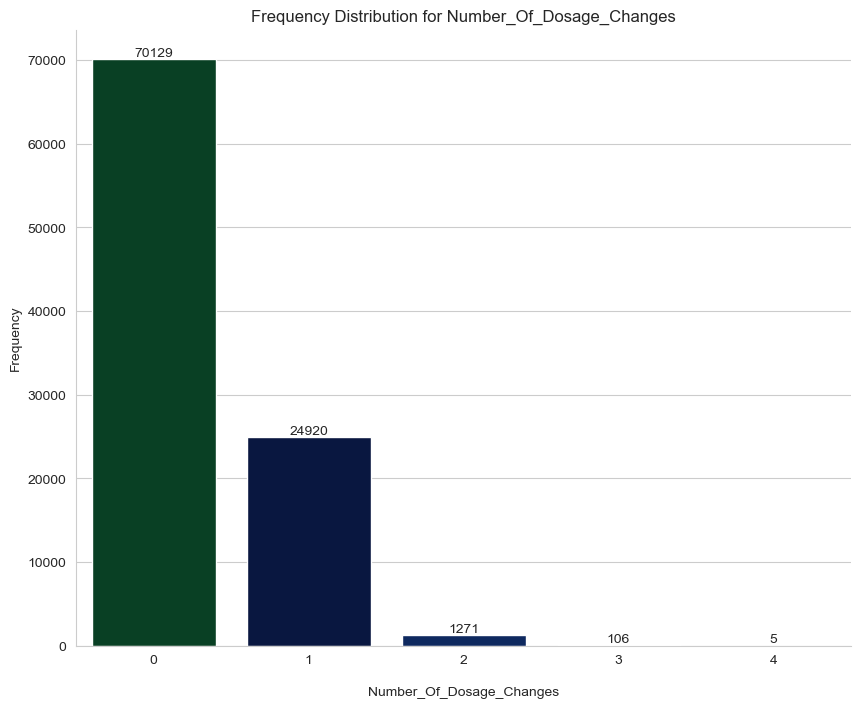

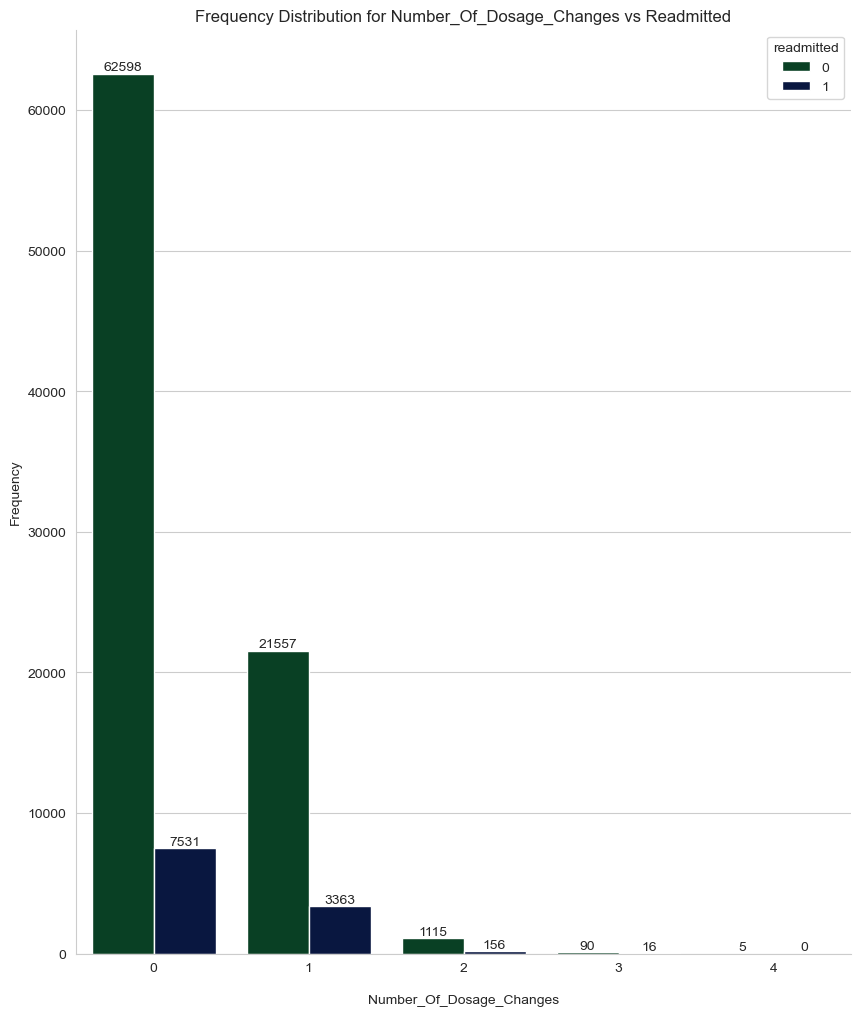

In [89]:
sns.set_palette('ocean')

# Creating a bar plot for number_of_dosage_changes vs readmitted
get_independent_versus_target_plot(diabetic_df_dosage_changes, 'number_of_dosage_changes')

In [90]:
def encode_readmitted(df):
    '''
    The encode_readmitted function takes a dataframe as input parameter and converts the readmitted column to a binary
    class by grouping 'NO' and '>30' days as 0 and '<30' days as 1. Readmission within 30 days is our class variable
    we are tyring to predict hence I kept it as 1.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that has the decomposed mapping
    '''
    new_df = df.copy()

    # Map the values as defined above
    new_df['readmitted'] = new_df['readmitted'].replace({'<30' : 1, 'NO' : 0, '>30' : 0})
    return new_df

diabetic_df_readmit_encoded = encode_readmitted(diabetic_df_dosage_changes)

In [91]:
def encode_age_intervals(df):
    '''
    The encode_age_intervals function takes a dataframe as input parameter and converts the age column which is 
    currently defined as intervals to a ordinal variable with the lowest age group as 0 and highest age group as 9.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data that has the decomposed mapping
    '''
    new_df = df.copy()
    age_map_dict = {'[0-10)' : 0, '[10-20)' : 1, '[20-30)' : 2, '[30-40)' : 3, '[40-50)' : 4, 
                    '[50-60)' : 5, '[60-70)' : 6, '[70-80)' : 7, '[80-90)' : 8, '[90-100)' : 9}
    new_df['age'] = new_df['age'].replace(age_map_dict)
    return new_df

diabetic_df_readmit_age_encoded = encode_age_intervals(diabetic_df_readmit_encoded)

In [92]:
# Referred : https://en.wikipedia.org/wiki/List_of_ICD-9_codes
# Referred : https://downloads.hindawi.com/journals/bmri/2014/781670.pdf

def diagnosis_mapper(code):
    '''
    The diagnosis_mapper function takes a code as input parameter and assigns the code description as given in the wikipidea link
    based on the code values ranges. 
      
            Parameters:

                    code (String) : A code representing the standard ICD-9 code
            
            Returns:
                    code_description (String) : A string that stores the code description corresponding to the ICD-9 code
    '''

    code_description = ''
    if (code.isnumeric() == False):
        code_description = 'external causes of injury and supplemental classification'
    else:
        code = pd.to_numeric(code)
        if (code >= 1 and code <= 139):
            code_description = 'infectious and parasitic diseases'
        elif (code >= 140 and code <= 239):
            code_description = 'neoplasms'
        elif (code >= 240 and code <= 279):
            code_description = 'endocrine, nutritional and metabolic diseases, and immunity disorders'
        elif (code >= 280 and code <= 289):
            code_description = 'diseases of the blood and blood-forming organs'
        elif (code >= 290 and code <= 319):
            code_description = 'mental disorders'
        elif (code >= 320 and code <= 389):
            code_description = 'diseases of the nervous system and sense organs'
        elif (code >= 390 and code <= 459):
            code_description = 'diseases of the circulatory system'
        elif (code >= 460 and code <= 519):
            code_description = 'diseases of the respiratory system'
        elif (code >= 520 and code <= 579):
            code_description = 'diseases of the digestive system'
        elif (code >= 580 and code <= 629):
            code_description = 'diseases of the genitourinary system system'
        elif (code >= 630 and code <= 679):
            code_description = 'complications of pregnancy, childbirth, and the puerperium'
        elif (code >= 680 and code <= 709):
            code_description = 'diseases of the skin and subcutaneous tissue'
        elif (code >= 710 and code <= 739):
            code_description = 'diseases of the musculoskeletal system and connective tissue'
        elif (code >= 740 and code <= 759):
            code_description = 'congenital anomalies'
        elif (code >= 760 and code <= 779):
            code_description = 'certain conditions originating in the perinatal period'
        elif (code >= 780 and code <= 799):
            code_description = 'symptoms, signs, and ill-defined conditions'
        elif (code >= 800 and code <= 999):
            code_description = 'injury and poisoning'
    return code_description

In [93]:
def handling_diagnosis_columns(df, col_list):
    '''
    The handling_diagnosis_columns function takes a dataframe and a column list as input parameter and calls the 
    diagnosis_mapper function defined above on all the columns in the col_list parameter. This ensures that rather than
    having so many different unique values for each code, the data is grouped into the categories described above.

            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    col_list (list) : A list of columns representing the diagnosis (ICD-9 codes) feature    
            
            Returns:
                    new_df (dataframe) : A dataframe representing the data with the newly decomposed mappings
    '''
    for col in col_list:
        df[col] = df[col].apply(diagnosis_mapper)
    return df
    
diagnosis_cols = ['diag_1', 'diag_2', 'diag_3']
diabetic_df_diag_encoded = handling_diagnosis_columns(diabetic_df_readmit_age_encoded, diagnosis_cols)

In [94]:
def encoding_nominal_columns_train(df, col_list):
    '''
    The encoding_nominal_columns_train function takes a dataframe and a col_list as input and performs One Hot Encoding using sklearn OneHotEncoder() on
    the categorical columns in the col_list. 
      
            Parameters:

                    df (dataframe) : A dataframe representing the training dataset from where records need to be read
                    col_list (list) : A list of nominal features    
            
            Returns:
                    return_df (dataframe) : A dataframe representing the train data with one hot encoded values
                    ohe (object) : A OneHotEncoder object which will be used to transform the test data
    '''
    ohe = OneHotEncoder()
    encoded_df = pd.DataFrame(ohe.fit_transform(df[col_list]).toarray(), index = df.index, columns = ohe.get_feature_names_out(col_list))
    return_df = df.join(encoded_df).drop(columns = col_list)
    return return_df, ohe

nominal_cols = ['race', 'admission_type_id', 'discharge_disposition_id', 
               'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'gender', 
               'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult']

diabetic_df_nominal_encoded, ohe = encoding_nominal_columns_train(diabetic_df_diag_encoded, nominal_cols)

In [95]:
def encoding_nominal_columns_test(df, col_list, ohe):
    '''
    The encoding_nominal_columns_test function takes a dataframe, a col_list and one hot encoder object as input and performs 
    One Hot Encoding using sklearn OneHotEncoder() on the categorical columns in the col_list. 
      
            Parameters:

                    df (dataframe) : A dataframe representing the test dataset from where records need to be read
                    col_list (list) : A list of nominal features  
                    ohe (object) : A OneHotEncoder object which will be used to transform the test data 
            
            Returns:
                    return_df (dataframe) : A dataframe representing the test data with one hot encoded values
    '''
    encoded_df = pd.DataFrame(ohe.transform(df[col_list]).toarray(), index = df.index, columns = ohe.get_feature_names_out(col_list))
    return_df = df.join(encoded_df).drop(columns = col_list)
    return return_df

In [96]:
def combine_patient_visits(df):
    '''
    The combine_patient_visits function takes a dataframe as input parameter and combines the 
    number_outpatient, number_emergency and number_inpatient columns into 1 named Number of Total Visits.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
            
            Returns:
                    df (dataframe) : A dataframe representing the data that has newly featured column
    '''
    df['Number of Total Visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
    df.drop(columns = ['number_outpatient', 'number_emergency', 'number_inpatient'], inplace = True) # Drop the redundant columns
    return df

diabetic_df_nominal_encoded = combine_patient_visits(diabetic_df_nominal_encoded)

In [97]:
def scaling_numerical_columns_train(df, col_list):
    '''
    The encoding_nominal_columns_train function takes a dataframe and a col_list as input and performs Normalization
    using sklearn Normalizer() on the numerical columns in the col_list. 
      
            Parameters:

                    df (dataframe) : A dataframe representing the training dataset from where records need to be read
                    col_list (list) : A list of numerical features    
            
            Returns:
                    return_df (dataframe) : A dataframe representing the train data with the scaled values
                    scaler (object) : A Normalizer object which will be used to transform the test data
    '''
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df[col_list]), index = df.index, columns = col_list)
    non_scaled_df = df.drop(columns = col_list)
    return_df = scaled_df.join(non_scaled_df)
    return return_df, scaler

numerical_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                 'number_diagnoses', 'number_of_dosage_changes',
                 'Number of Total Visits']

diabetic_df_nominal_encoded_numerical_scaled, scaler = scaling_numerical_columns_train(diabetic_df_nominal_encoded, numerical_cols)

In [98]:
def scaling_numerical_columns_test(df, col_list, scaler):
    '''
    The scaling_numerical_columns_test function takes a dataframe and a col_list and a MinMaxScaler object as 
    input and performs Normalization using sklearn Normalizer() on the numerical columns in the col_list. 
      
            Parameters:

                    df (dataframe) : A dataframe representing the training dataset from where records need to be read
                    col_list (list) : A list of numerical features
                    scaler (object) : A Normalizer object which will be used to transform the test data   
            
            Returns:
                    return_df (dataframe) : A dataframe representing the train data with the scaled values
    '''
    scaled_df = pd.DataFrame(scaler.transform(df[col_list]), index = df.index, columns = col_list)
    non_scaled_df = df.drop(columns = col_list)
    return_df = scaled_df.join(non_scaled_df)
    return return_df

In [99]:
# Oversampling the minority class
def oversampling_minority(df, categorical_columns):
    '''
    The oversampling_minority function takes a dataframe and a categorical column list as input parameters and uses the SMOTENC library to oversample
    the minority class.
      
            Parameters:

                    df (dataframe) : A dataframe representing the dataset from where records need to be read
                    categorical_columns (list) : A list of categorical columns
            
            Returns:

                    df_oversampled_minority (dataframe) : A dataframe that has oversampled minority class (50-50 split between the 2 classes)
                    
    '''
    categorical_columns_index = [df.columns.get_loc(c) for c in categorical_columns if c in df]
    X_train = df.drop(columns = 'readmitted').copy()
    y_train = df['readmitted'].copy()
    sm = SMOTENC(random_state = 633, categorical_features = categorical_columns_index, k_neighbors = 10)
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    df_oversampled_minority = pd.concat([X_train_oversampled, y_train_oversampled], axis = 1)
    return df_oversampled_minority

In [100]:
def preprocessing_data_train(df, medications_col_list, diagnosis_cols_list, nominal_cols_list, numerical_cols_list):
    
    # Calling all the functions defined above to get the preprocessing working on training data

    df = cleaning_nulls_removing_columns(df)
    df = cleaning_admission_type_id(df)
    df = cleaning_discharge_disposition_id(df)
    df = cleaning_admission_source_id(df)
    df = cleaning_medications_features(df, medications_col_list)
    df = encode_readmitted(df)
    df = encode_age_intervals(df)
    df = handling_diagnosis_columns(df, diagnosis_cols_list)
    df = combine_patient_visits(df)
    df = oversampling_minority(df, nominal_cols_list + ['readmitted'])
    df, ohe = encoding_nominal_columns_train(df, nominal_cols_list)
    df, scaler = scaling_numerical_columns_train(df, numerical_cols_list)

    return df, ohe, scaler

# Transformed training data
diabetic_train_df, ohe, scaler = preprocessing_data_train(train_df, medications, diagnosis_cols, nominal_cols, numerical_cols)

In [101]:
def preprocessing_data_test(df, medications_col_list, diagnosis_cols_list, nominal_cols_list, numerical_cols_list, ohe, scaler):

    # Calling all the functions defined above to get the preprocessing working on test data

    df = cleaning_nulls_removing_columns(df)
    df = cleaning_admission_type_id(df)
    df = cleaning_discharge_disposition_id(df)
    df = cleaning_admission_source_id(df)
    df = cleaning_medications_features(df, medications_col_list)
    df = encode_readmitted(df)
    df = encode_age_intervals(df)
    df = handling_diagnosis_columns(df, diagnosis_cols_list)
    df = combine_patient_visits(df)
    df = encoding_nominal_columns_test(df, nominal_cols_list, ohe)
    df = scaling_numerical_columns_test(df, numerical_cols_list, scaler)

    return df

# Transformed test data
diabetic_test_df = preprocessing_data_test(test_df, medications, diagnosis_cols, nominal_cols, numerical_cols, ohe, scaler)

In [102]:
# Calling all the functions defined above to get the preprocessing working on validation data

diabetic_val_df = preprocessing_data_test(val_df, medications, diagnosis_cols, nominal_cols, numerical_cols, ohe, scaler)

## Model Building

In [103]:
print("There are " + str(diabetic_train_df.shape[0]) + " rows and " + str(diabetic_train_df.shape[1]) + " columns in the training data.")
print()
print("There are " + str(diabetic_test_df.shape[0]) + " rows and " + str(diabetic_test_df.shape[1]) + " columns in the test data.")
print()
print("There are " + str(diabetic_val_df.shape[0]) + " rows and " + str(diabetic_val_df.shape[1]) + " columns in the validation data.")

# Splitting data into X_train, y_train, X_test, y_test, X_val, y_val
X_train = diabetic_train_df.drop(columns = ["readmitted"]).copy()
y_train = diabetic_train_df["readmitted"].copy()
X_test = diabetic_test_df.drop(columns = ["readmitted"]).copy()
y_test = diabetic_test_df["readmitted"].copy()
X_val = diabetic_val_df.drop(columns = ["readmitted"]).copy()
y_val = diabetic_val_df["readmitted"].copy()

There are 108650 rows and 92 columns in the training data.

There are 24095 rows and 92 columns in the test data.

There are 10882 rows and 92 columns in the validation data.


In [104]:
# Creating a function to fit the model and get the statistics
def fitting_classification_model_with_stats(name, clf, X_train, y_train, X_test, y_test):
    '''
    The fitting_classification_model_with_stats function takes a name, classification model, X_train, y_train, X_test, y_test as input parameters and 
    fits the model passed in the parameter on the training data. It then uses the model to predict the values of training and test data. 
    It calculates the recall scores, the precision scores, the classification report and finally the confusion matrix for the model.
      
            Parameters:

                    name (string) : A String representing the name of the model used
                    clf (model) : A classification model
                    X_train (dataframe): A dataframe representing the training features
                    y_train (dataframe): A dataframe representing the training class labels
                    X_test (dataframe): A dataframe representing the test features
                    y_test (dataframe): A dataframe representing the test class labels
            
            Returns:

                    y_pred_test (array) : An array representing the predictions on test data
                    
    '''
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    print('The recall score on training data is : ' + str(round(recall_score(y_train, y_pred_train), 3)))
    print('The recall score on validation data is : ' + str(round(recall_score(y_test, y_pred_test), 3)))
    print()
    print('The precision score on training data is : ' + str(round(precision_score(y_train, y_pred_train), 3)))
    print('The precision score on validation data is : ' + str(round(precision_score(y_test, y_pred_test), 3)))
    print()
    print('---------------------- Classification Report on Training Data for Base ' + name + ' Classifier ----------------------')
    print(classification_report(y_train, y_pred_train))
    print()
    print('---------------------- Classification Report on Validation Data for Base ' + name + ' Classifier ----------------------')
    print(classification_report(y_test, y_pred_test))
    # Printing the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Reds', annot_kws = {"fontsize": 14}, fmt = 'g')
    ax.set_title('Confusion Matrix for the Base ' + name + ' Classifier \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');
    ax.xaxis.set_ticklabels(['Not Readmitted','Readmitted']);
    ax.yaxis.set_ticklabels(['Not Readmitted','Readmitted']);
    return y_pred_test

### Logistic Regression Model

The recall score on training data is : 0.801
The recall score on validation data is : 0.309

The precision score on training data is : 0.765
The precision score on validation data is : 0.132

---------------------- Classification Report on Training Data for Base Logistic Regression Classifier ----------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     54325
           1       0.77      0.80      0.78     54325

    accuracy                           0.78    108650
   macro avg       0.78      0.78      0.78    108650
weighted avg       0.78      0.78      0.78    108650


---------------------- Classification Report on Validation Data for Base Logistic Regression Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      9710
           1       0.13      0.31      0.19      1172

    accuracy                           0.71     10882
   macro a

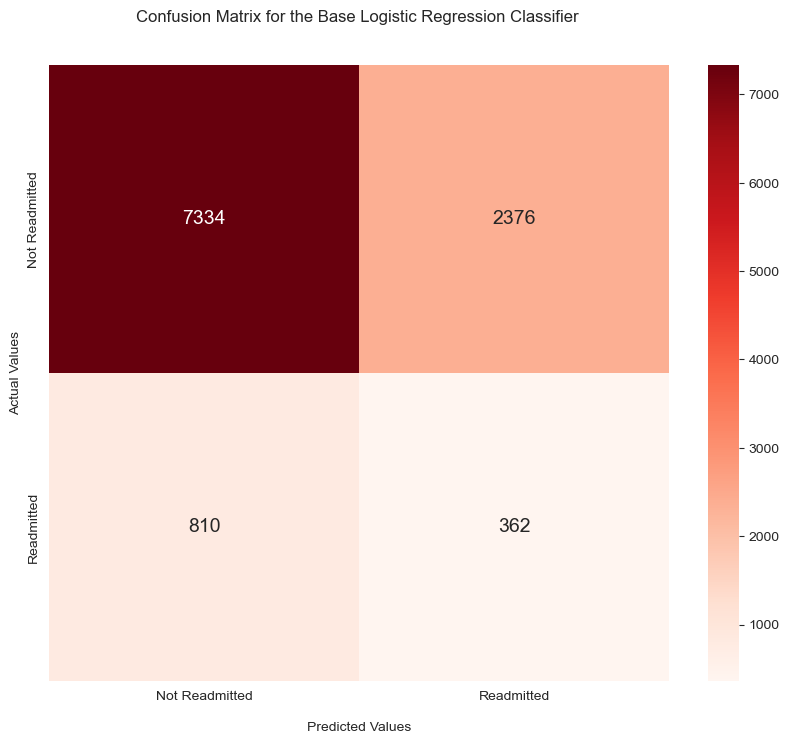

In [105]:
# Dictionary for storing all the models

models_dict = dict() # Stores all the models
f1_dict = dict() # Stores all the f1 scores for the models
precision_dict = dict() # Stores all the precision scores for the models
recall_dict = dict() # Stores all the recall scores for the models

# Fitting Logistic Regression model
lr_clf = LogisticRegression(random_state = 633, max_iter = 1000) # max_iter = 500 to prevent the convergence warning
lr_y_pred_test = fitting_classification_model_with_stats('Logistic Regression', lr_clf, X_train, y_train, X_val, y_val)
models_dict['Logistic Regression'] = lr_clf
f1_dict['Logistic Regression'] = f1_score(y_val, lr_y_pred_test)
recall_dict['Logistic Regression'] = recall_score(y_val, lr_y_pred_test)
precision_dict['Logistic Regression'] = precision_score(y_val, lr_y_pred_test)

### Random Forest Model

The recall score on training data is : 1.0
The recall score on validation data is : 0.154

The precision score on training data is : 1.0
The precision score on validation data is : 0.14

---------------------- Classification Report on Training Data for Base Random Forest Classifier ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54325
           1       1.00      1.00      1.00     54325

    accuracy                           1.00    108650
   macro avg       1.00      1.00      1.00    108650
weighted avg       1.00      1.00      1.00    108650


---------------------- Classification Report on Validation Data for Base Random Forest Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      9710
           1       0.14      0.15      0.15      1172

    accuracy                           0.81     10882
   macro avg       0.52    

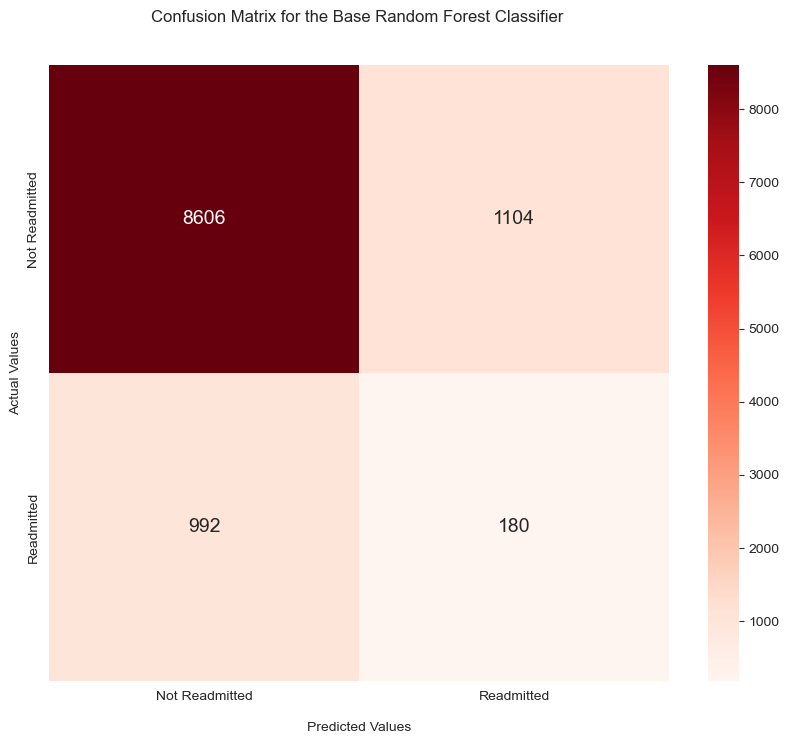

In [106]:
# Fitting Random Forest model
rf_clf = RandomForestClassifier(random_state = 633)
rf_y_pred_test = fitting_classification_model_with_stats('Random Forest', rf_clf, X_train, y_train, X_val, y_val)
models_dict['Random Forest'] = rf_clf
f1_dict['Random Forest'] = f1_score(y_val, rf_y_pred_test)
recall_dict['Random Forest'] = recall_score(y_val, rf_y_pred_test)
precision_dict['Random Forest'] = precision_score(y_val, rf_y_pred_test)

### XGBoost Model

The recall score on training data is : 0.856
The recall score on validation data is : 0.248

The precision score on training data is : 0.843
The precision score on validation data is : 0.144

---------------------- Classification Report on Training Data for Base XGBoost Classifier ----------------------
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     54325
           1       0.84      0.86      0.85     54325

    accuracy                           0.85    108650
   macro avg       0.85      0.85      0.85    108650
weighted avg       0.85      0.85      0.85    108650


---------------------- Classification Report on Validation Data for Base XGBoost Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      9710
           1       0.14      0.25      0.18      1172

    accuracy                           0.76     10882
   macro avg       0.52      0.54 

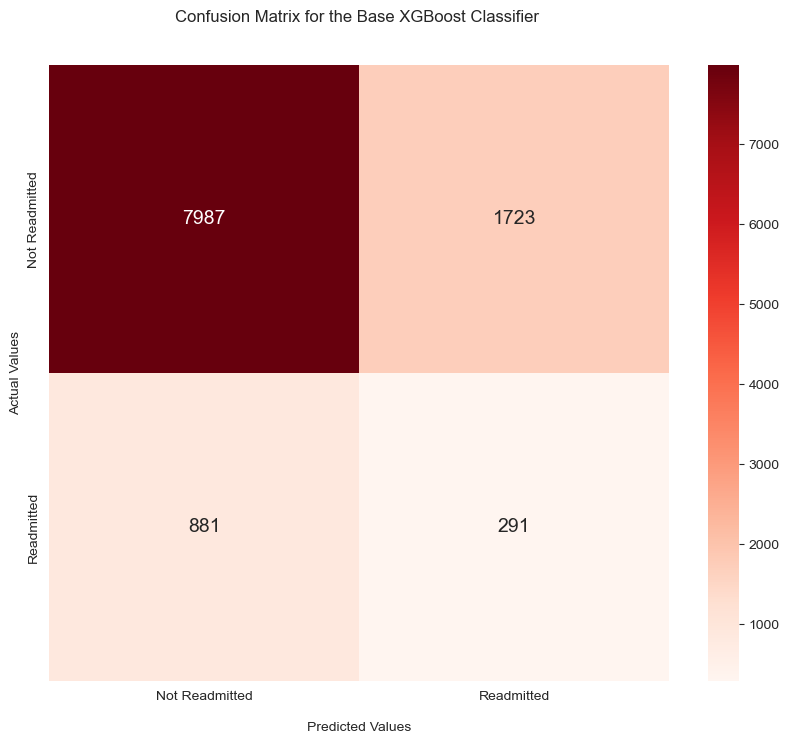

In [107]:
# Fitting XGBoost Classifier
xgb_clf = XGBClassifier(random_state = 633)
xgb_y_pred_test = fitting_classification_model_with_stats('XGBoost', xgb_clf, X_train, y_train, X_val, y_val)
models_dict['XGBoost'] = xgb_clf
f1_dict['XGBoost'] = f1_score(y_val, xgb_y_pred_test)
recall_dict['XGBoost'] = recall_score(y_val, xgb_y_pred_test)
precision_dict['XGBoost'] = precision_score(y_val, xgb_y_pred_test)

In [108]:
metrics_df = pd.DataFrame({'F1_Baseline' : f1_dict, 'Recall_Baseline' : recall_dict, 'Precision_Baseline' : precision_dict})
metrics_df

,F1_Baseline,Recall_Baseline,Precision_Baseline
Logistic Regression,0.185166,0.308874,0.132213
Random Forest,0.146580,0.153584,0.140187
XGBoost,0.182674,0.248294,0.144489


### Observations

I have fit 3 classification models namely Logistic Regression, Random Forest and XGBoost. Since, this is a hospital readmission problem, the metric we would consider most important would be `Recall`. This is because we don't want to miss out labelling patients as being readmitted when they actually will be readmitted, i.e. we want to decrease the *False Negatives* in our prediction. Thus, there will always be a trade-off between precision and recall. Also, since this is an imbalanced class problem, we can look at the weighted average of the recall scores overall from the classification report or look at the recall scores for the positive instances. These scores are shown above in the metrics dataframe. 

1. We can clearly observe that the baseline Random Forest model heavily overfits the data.

2. Logistic Regression performs best in terms of recall, which is our favoured evaluation metric for this problem statement.

## Feature Selection

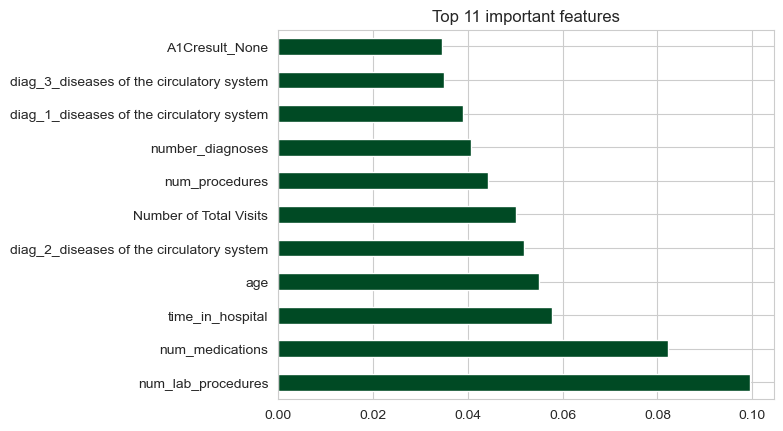

In [109]:
# Getting the top n features
feat_importances = pd.Series(models_dict['Random Forest'].feature_importances_, index = X_train.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.title("Top 11 important features")
plt.show()

In [110]:
top_11_features = feat_importances.sort_values(ascending = False)[:11].index.to_list()
print('The top 11 features are : ' + str(top_11_features))

The top 11 features are : ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'age', 'diag_2_diseases of the circulatory system', 'Number of Total Visits', 'num_procedures', 'number_diagnoses', 'diag_1_diseases of the circulatory system', 'diag_3_diseases of the circulatory system', 'A1Cresult_None']


## Fitting Models on Selected Features

### Logistic Regression Model on Selected Features

The recall score on training data is : 0.725
The recall score on validation data is : 0.337

The precision score on training data is : 0.722
The precision score on validation data is : 0.126

---------------------- Classification Report on Training Data for Base Logistic Regression Classifier ----------------------
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     54325
           1       0.72      0.73      0.72     54325

    accuracy                           0.72    108650
   macro avg       0.72      0.72      0.72    108650
weighted avg       0.72      0.72      0.72    108650


---------------------- Classification Report on Validation Data for Base Logistic Regression Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      9710
           1       0.13      0.34      0.18      1172

    accuracy                           0.68     10882
   macro a

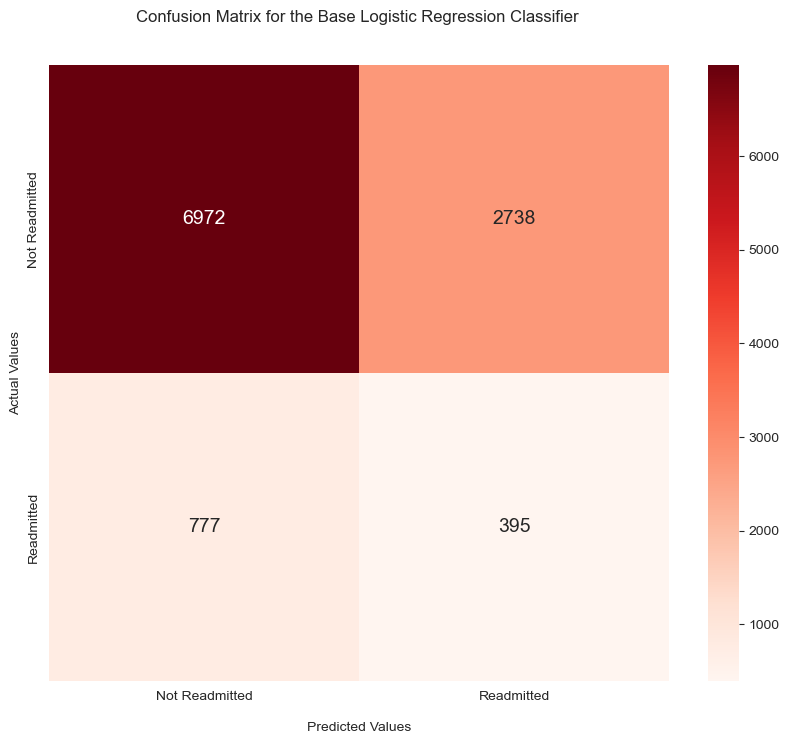

In [111]:
# Dictionary for storing all the models
models_dict_fs = dict()
f1_dict_fs = dict()
precision_dict_fs = dict()
recall_dict_fs = dict()
# Fitting Logistic Regression model
lr_clf_fs = LogisticRegression(random_state = 633, max_iter = 1000)
lr_y_pred_test_fs = fitting_classification_model_with_stats('Logistic Regression', lr_clf_fs, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
models_dict_fs['Logistic Regression'] = lr_clf_fs
f1_dict_fs['Logistic Regression'] = f1_score(y_val, lr_y_pred_test_fs)
recall_dict_fs['Logistic Regression'] = recall_score(y_val, lr_y_pred_test_fs)
precision_dict_fs['Logistic Regression'] = precision_score(y_val, lr_y_pred_test_fs)

### Random Forest Model on Selected Features

The recall score on training data is : 0.999
The recall score on validation data is : 0.254

The precision score on training data is : 0.998
The precision score on validation data is : 0.137

---------------------- Classification Report on Training Data for Base Random Forest Classifier ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54325
           1       1.00      1.00      1.00     54325

    accuracy                           1.00    108650
   macro avg       1.00      1.00      1.00    108650
weighted avg       1.00      1.00      1.00    108650


---------------------- Classification Report on Validation Data for Base Random Forest Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      9710
           1       0.14      0.25      0.18      1172

    accuracy                           0.75     10882
   macro avg       0.5

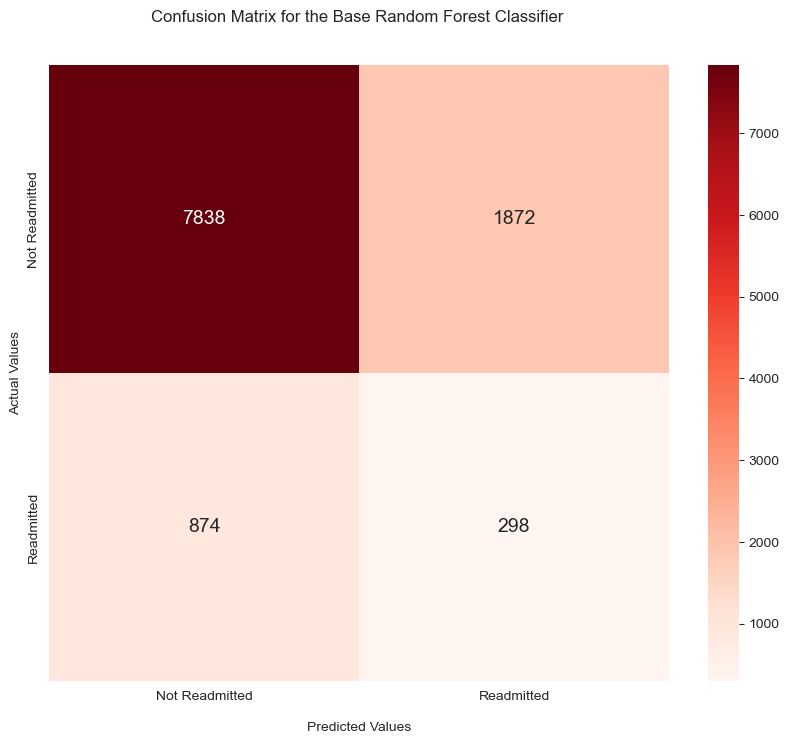

In [112]:
# Fitting Random Forest model
rf_clf_fs = RandomForestClassifier(random_state = 633)
rf_y_pred_test_fs = fitting_classification_model_with_stats('Random Forest', rf_clf_fs, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
models_dict_fs['Random Forest'] = rf_clf_fs
f1_dict_fs['Random Forest'] = f1_score(y_val, rf_y_pred_test_fs)
recall_dict_fs['Random Forest'] = recall_score(y_val, rf_y_pred_test_fs)
precision_dict_fs['Random Forest'] = precision_score(y_val, rf_y_pred_test_fs)

### XGBoost Model on Selected Features

The recall score on training data is : 0.796
The recall score on validation data is : 0.288

The precision score on training data is : 0.791
The precision score on validation data is : 0.132

---------------------- Classification Report on Training Data for Base XGBoost Classifier ----------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     54325
           1       0.79      0.80      0.79     54325

    accuracy                           0.79    108650
   macro avg       0.79      0.79      0.79    108650
weighted avg       0.79      0.79      0.79    108650


---------------------- Classification Report on Validation Data for Base XGBoost Classifier ----------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      9710
           1       0.13      0.29      0.18      1172

    accuracy                           0.72     10882
   macro avg       0.52      0.53 

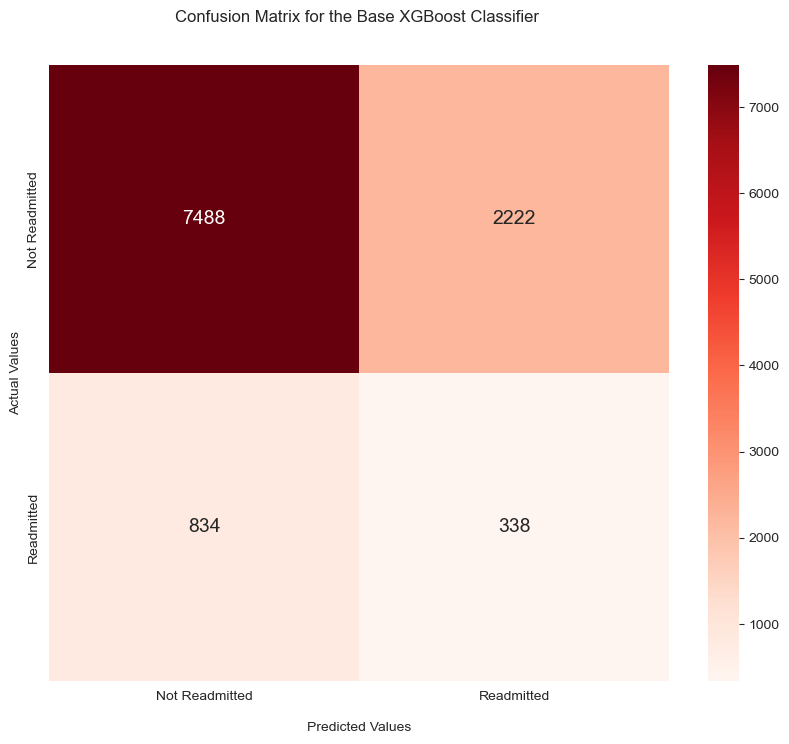

In [113]:
# Fitting XGBoost model
xgb_clf_fs = XGBClassifier(random_state = 633)
xgb_y_pred_test_fs = fitting_classification_model_with_stats('XGBoost', xgb_clf_fs, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
models_dict_fs['XGBoost'] = rf_clf_fs
f1_dict_fs['XGBoost'] = f1_score(y_val, xgb_y_pred_test_fs)
recall_dict_fs['XGBoost'] = recall_score(y_val, xgb_y_pred_test_fs)
precision_dict_fs['XGBoost'] = precision_score(y_val, xgb_y_pred_test_fs)

In [114]:
metrics_df_fs = pd.DataFrame({'F1_Baseline_Selected_features' : f1_dict_fs, 'Recall_Baseline_Selected_features' : recall_dict_fs, 'Precision_Baseline_Selected_features' : precision_dict_fs})
concat_df = pd.concat([metrics_df, metrics_df_fs], axis = 1)
concat_df

,F1_Baseline,Recall_Baseline,Precision_Baseline,F1_Baseline_Selected_features,Recall_Baseline_Selected_features,Precision_Baseline_Selected_features
Logistic Regression,0.185166,0.308874,0.132213,0.183508,0.337031,0.126077
Random Forest,0.146580,0.153584,0.140187,0.178336,0.254266,0.137327
XGBoost,0.182674,0.248294,0.144489,0.181136,0.288396,0.132031


### Observations

Feature selection is an iterative process where you keep checking how many features will result in the best model. The best model is returned when there are top 10 - 12 features.

1. We can observe that after feature selection, the performances of all the models based on recall values has increased.

2. All these models are still baseline models so they will overfit the data a bit.

3. Logistic Regression still performs the best in terms of recall. Additionally, there were 810 False Negatives for the LR model. These have been decreased to 777 now. This means that our model has decreased the number of False Negatives which has led to an increase of the recall score.

Since, Logistic Regression is still performing the best, we can move ahead and do some hyperparameter tuning for this model.

## Hyperparameter Tuning

In [115]:
best_params_dict = dict()
best_estimator_dict = dict()
f1_dict_grid_search = dict()
recall_dict_grid_search = dict()
precision_dict_grid_search = dict()

def hyperparameter_tuning(name, clf, param_grid, X_train, y_train, X_test, y_test):
    '''
    The hyperparameter_tuning function takes a name, classification model, parameters grid, X_train, y_train, X_test, y_test as input parameters and 
    performs hyperparameter tuning using GridSearchCV in sklearn. It uses "Recall" as the scoring parameter and fits 5-folds for each classification
    model. It uses the best best params and the best estimator to predict the values for training and test data. All the statistics are also printed as 
    before.
      
            Parameters:

                    name (string) : A String representing the name of the model used
                    clf (model) : A classification model
                    param_grid (dict) : A dictionary representing the values to use in the gridsearch
                    X_train (dataframe): A dataframe representing the training features
                    y_train (dataframe): A dataframe representing the training class labels
                    X_test (dataframe): A dataframe representing the test features
                    y_test (dataframe): A dataframe representing the test class labels
            
            Returns:
 
                    best_clf_params (dict) : A dictionary representing the best parameters for the model returned by GridSearch
                    best_clf_model (model) : A classification model with the best parameters returned by GridSearch
                    y_pred_test_best_gs (array) : An array of predictions on test data using the best estimator from GridSearch
                    
    '''
    
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring = 'recall')
    grid_search.fit(X_train, y_train)
    best_clf_params = grid_search.best_params_
    best_clf_model = grid_search.best_estimator_
    y_pred_train_best_gs = best_clf_model.predict(X_train)
    y_pred_test_best_gs = best_clf_model.predict(X_test)
    print('---------------------- Classification Report on Training Data for GridSearch ' + name + ' Classifier ----------------------')
    print()
    # print(evaluate_model(best_rf_clf_model, X_train, y_train))
    print(classification_report(y_train, y_pred_train_best_gs))
    print()
    # Performance evaluation of the classification model from grid search on test data
    print('---------------------- Classification Report on Validation Data for GridSearch ' + name + ' Classifier ----------------------')
    print()
    # print(evaluate_model(best_rf_clf_model, X_test, y_test))
    print(classification_report(y_test, y_pred_test_best_gs))
    print()
    cf_matrix = confusion_matrix(y_test, y_pred_test_best_gs)
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Reds', annot_kws = {"fontsize": 14}, fmt = 'g')
    ax.set_title('Confusion Matrix for the Best Grid Search ' + name + ' Classifier\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');
    ax.xaxis.set_ticklabels(['Not Readmitted','Readmitted']);
    ax.yaxis.set_ticklabels(['Not Readmitted','Readmitted']);
    return best_clf_params, best_clf_model, y_pred_test_best_gs

### Logistic Regression GridSearch

Fitting 5 folds for each of 9 candidates, totalling 45 fits
---------------------- Classification Report on Training Data for GridSearch Logistic Regression Classifier ----------------------

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     54325
           1       0.72      0.73      0.72     54325

    accuracy                           0.72    108650
   macro avg       0.72      0.72      0.72    108650
weighted avg       0.72      0.72      0.72    108650


---------------------- Classification Report on Validation Data for GridSearch Logistic Regression Classifier ----------------------

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      9710
           1       0.13      0.34      0.18      1172

    accuracy                           0.68     10882
   macro avg       0.51      0.53      0.49     10882
weighted avg       0.82      0.68      0.73     10882




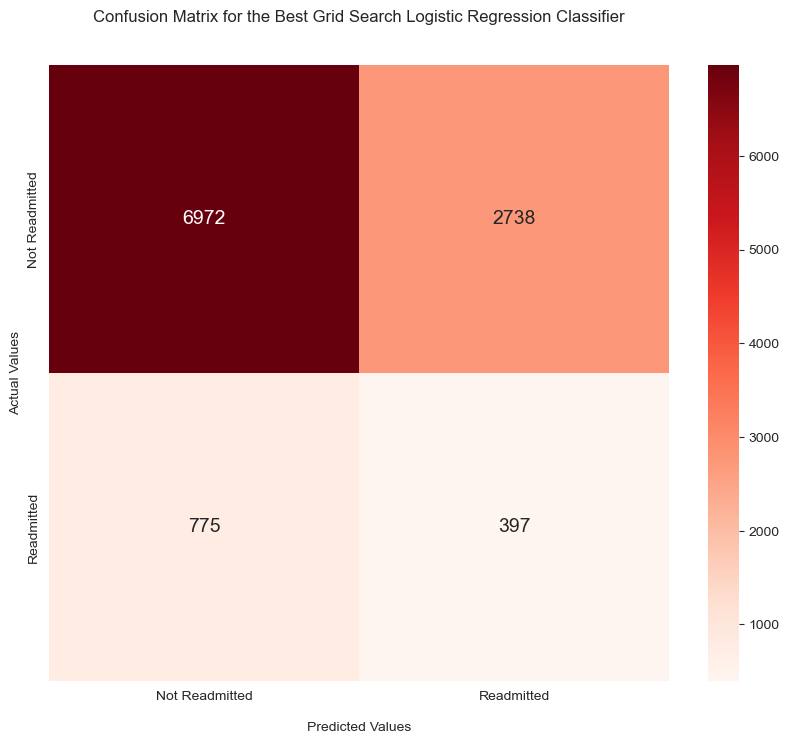

In [116]:
lr_clf_gs = LogisticRegression(random_state = 633, max_iter = 1000)
lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'class_weight': ['balanced'],
}
best_lr_clf_params, best_lr_clf_model, y_pred_test_best_gs_lr = hyperparameter_tuning('Logistic Regression', lr_clf_gs, lr_param_grid, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
best_params_dict['Logistic Regression'] = best_lr_clf_params
best_estimator_dict['Logistic Regression'] = best_lr_clf_model
f1_dict_grid_search['Logistic Regression'] = f1_score(y_val, y_pred_test_best_gs_lr)
recall_dict_grid_search['Logistic Regression'] = recall_score(y_val, y_pred_test_best_gs_lr)
precision_dict_grid_search['Logistic Regression'] = precision_score(y_val, y_pred_test_best_gs_lr)

*Below is the GridSearch being run on Random Forest and XGBoost but the codes have been commented out because they might take a lot of time on a different processor. So, please if you want to run the code make sure to comment it out. But, both these models resulted in worse performance as compared to Logistic Regression.*

### Random Forest GridSearch

In [117]:
# rf_clf_gs = RandomForestClassifier(random_state = 633)

# rf_param_grid = {
#     'bootstrap': [True],
#     'max_depth': [2, 4, 8, 16, 32],
#     'max_features': ['log2', 'sqrt'],
#     'n_estimators': [100, 200, 400, 800, 1600]
#     }

# best_rf_clf_params, best_rf_clf_model, y_pred_test_best_gs_rf = hyperparameter_tuning('Random Forest', rf_clf_gs, rf_param_grid, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
# best_params_dict['Random Forest'] = best_rf_clf_params
# best_estimator_dict['Random Forest'] = best_rf_clf_model
# f1_dict_grid_search['Random Forest'] = f1_score(y_val, y_pred_test_best_gs_rf)
# recall_dict_grid_search['Random Forest'] = recall_score(y_val, y_pred_test_best_gs_rf)
# precision_dict_grid_search['Random Forest'] = precision_score(y_val, y_pred_test_best_gs_rf)


### XGBoost GridSearch

In [118]:
# xgb_clf_gs = XGBClassifier(random_state = 633)

# xgb_param_grid = {
#     'max_depth' : [2, 4, 8, 16, 32],
#     'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
#     'n_estimators': [200, 400, 800, 1600]
#     }

# best_xgb_clf_params, best_xgb_clf_model, y_pred_test_best_gs_xgb = hyperparameter_tuning('XGBoost', xgb_clf_gs, xgb_param_grid, X_train[top_11_features], y_train, X_val[top_11_features], y_val)
# best_params_dict['XGBoost'] = best_xgb_clf_params
# best_estimator_dict['XGBoost'] = best_xgb_clf_model
# f1_dict_grid_search['XGBoost'] = f1_score(y_val, y_pred_test_best_gs_xgb)
# recall_dict_grid_search['XGBoost'] = recall_score(y_val, y_pred_test_best_gs_xgb)
# precision_dict_grid_search['XGBoost'] = precision_score(y_val, y_pred_test_best_gs_xgb)

In [119]:
metrics_df_gs = pd.DataFrame({'F1' : f1_dict_grid_search, 'Recall' : recall_dict_grid_search, 'Precision' : precision_dict_grid_search})
metrics_df_gs

,F1,Recall,Precision
Logistic Regression,0.184351,0.338737,0.126635


### Observations

We can see that there is a very small change in the recall value after applying grid search i.e. the False Negative values have decreased from 777 in the feature selected baseline mdoel to 775 in the gridsearch model . Currently, this is the best model after hyperparameter tuning. We can now go ahead and finally test the model on previously unseen test data. Till now, we have been checking the model performance on validation data to get an idea of the model performance. Now, it is time to test the model on the test data which was held out till now. 

## Final Evaluations

The best model after hyperparameter tuning based on recall scores looks as follows: 
LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=633)

The recall score on training data is : 0.725
The recall score on test data is : 0.342

The precision score on training data is : 0.722
The precision score on test data is : 0.133

The classification report looks as follows : 

              precision    recall  f1-score   support

           0       0.89      0.71      0.79     21330
           1       0.13      0.34      0.19      2765

    accuracy                           0.67     24095
   macro avg       0.51      0.53      0.49     24095
weighted avg       0.81      0.67      0.72     24095




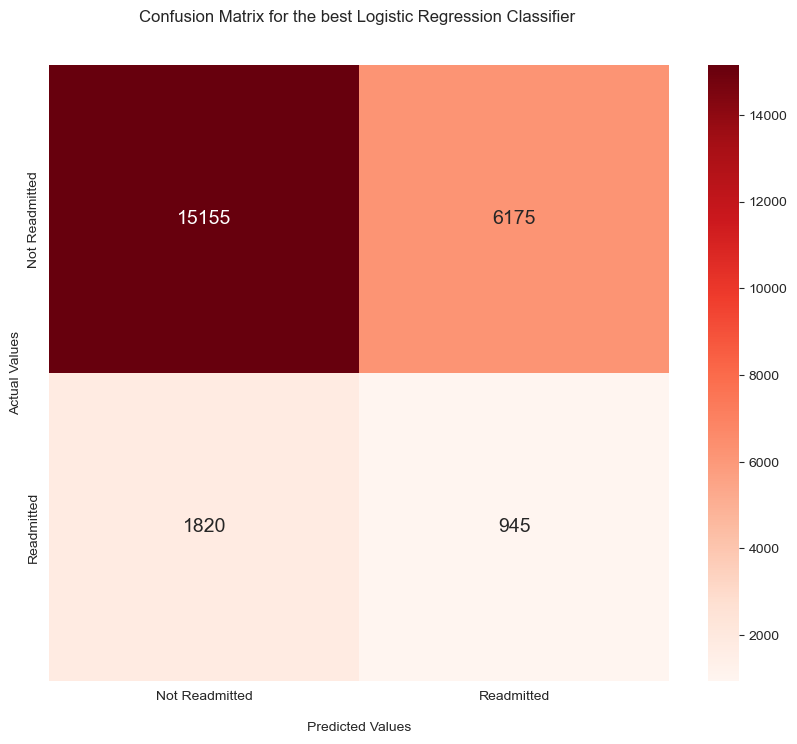

In [120]:
# Getting the best model with the highest recall for readmission

best_model_recall_name = max(recall_dict_grid_search, key = recall_dict_grid_search.get)
best_model = best_estimator_dict[best_model_recall_name]
print("The best model after hyperparameter tuning based on recall scores looks as follows: ")
print(best_model)
# Final predictions and evaluation on test data
print()
y_train_pred_final = best_model.predict(X_train[top_11_features])
y_test_pred_final = best_model.predict(X_test[top_11_features])
print("The recall score on training data is : " + str(round(recall_score(y_train, y_train_pred_final), 3)))
print("The recall score on test data is : " + str(round(recall_score(y_test, y_test_pred_final), 3)))
print()
print("The precision score on training data is : " + str(round(precision_score(y_train, y_train_pred_final), 3)))
print("The precision score on test data is : " + str(round(precision_score(y_test, y_test_pred_final), 3)))
print()
print("The classification report looks as follows : \n")
print(classification_report(y_test, y_test_pred_final))
print()
cf_matrix = confusion_matrix(y_test, y_test_pred_final)
plt.figure(figsize = (10, 8))
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Reds', annot_kws = {"fontsize": 14}, fmt = 'g')
ax.set_title('Confusion Matrix for the best Logistic Regression Classifier \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
ax.xaxis.set_ticklabels(['Not Readmitted','Readmitted']);
ax.yaxis.set_ticklabels(['Not Readmitted','Readmitted']);

### Precision-Recall (Tradeoff) vs Threshold

We can get the probabilities of our predictions from Logistic Regression. These probabilities represent the probability of a sample being predicted as positive class i.e. being readmitted within 30 days. By default, the threshold is 0.5. But, we can check the effect of threshold changes both on precision and recall. Keeping a lower threshold in medical problems is much more important because we take a conservative approach and classify more people as belonging to the positive class. This is because we don't want the case where an actual patient is readmitted but our model didn't predict that i.e. we want to decrease our False Negatives. Decreasing the threshold increases the recall but also decreases the precision because our False Positives increase. This is a tradeoff. Since we want our recall to be higher, we can decrease our threshold as the precision does not change much as seen in the graph below.

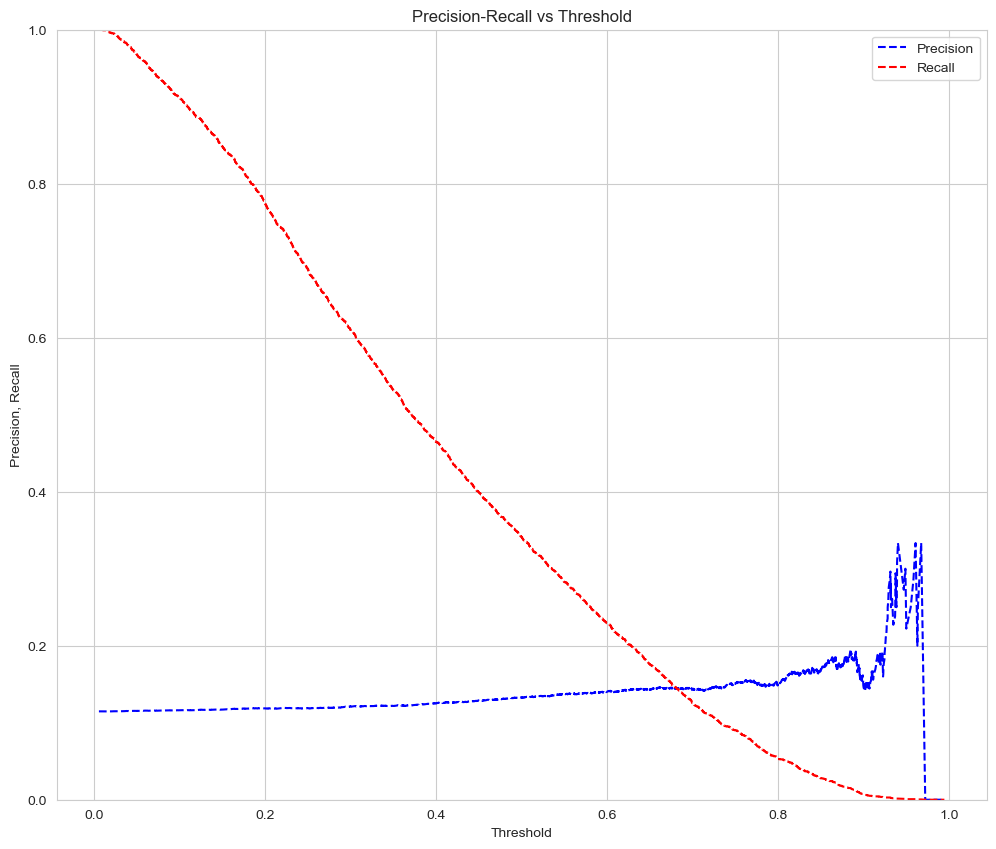

In [121]:
# Referred : https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

pred_y = best_model.predict(X_test[top_11_features]) 

probs_y = best_model.predict_proba(X_test[top_11_features]) 

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

pr_auc = auc(recall, precision)

plt.figure(figsize = (12, 10))
plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label = "Precision");
plt.plot(thresholds, recall[: -1], "r--", label = "Recall");
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc = "upper right")
plt.ylim([0, 1]);

From the graph above, we can see that a threshold of ~0.2 would increase the recall a lot as compared to the default threshold of 0.5. At threshold = 0.2, the precision is more or less equal to the value at threshold = 0.5. So, we will create new predictions and classify all samples which have probability > 0.2 as being readmitted to hospital within 30 days.

The recall after decreasing the threshold to 0.2 is : 0.775

The classification report looks as follows : 


              precision    recall  f1-score   support

           0       0.90      0.25      0.40     21330
           1       0.12      0.78      0.21      2765

    accuracy                           0.31     24095
   macro avg       0.51      0.51      0.30     24095
weighted avg       0.81      0.31      0.37     24095



-------------------------------------- Final Confusion Matrix ----------------------------------------


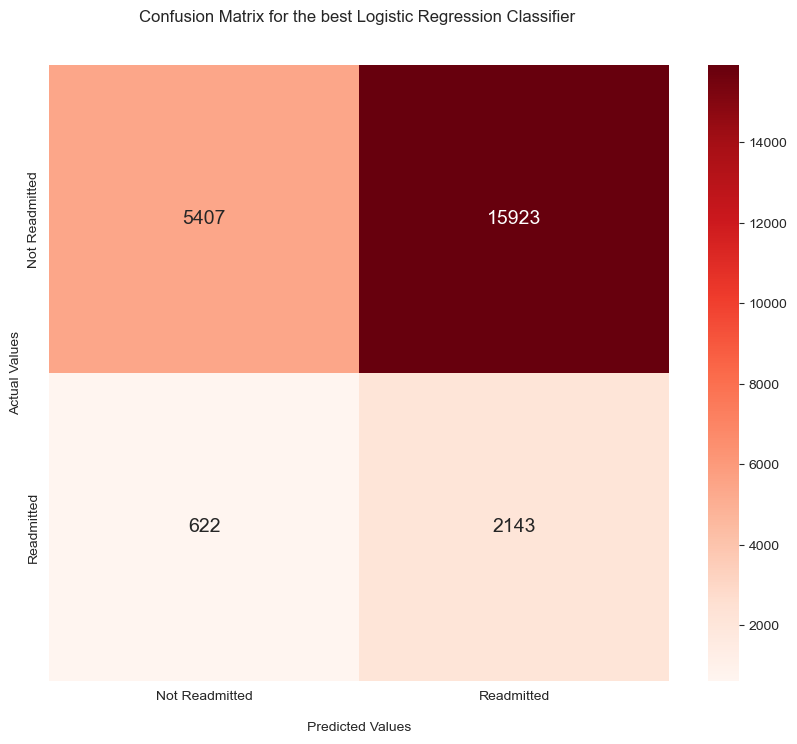

In [122]:
def update_threshold_predictions(X_test, threshold, clf):
    '''
    The update_threshold_predictions function takes a X_test, threshold and classification model as input parameters and uses the predict_proba
    method to get the probability values for the predictions. Then, it declares all the samples where probability is greater than threshold as belonging
    to the positive class.
      
            Parameters:

                    X_test (dataframe): A dataframe representing the test features
                    threshold (float) : A decimal value indicating the threshold to use
                    clf (model) : A classification model
            
            Returns:

                    probs (array) : An array representing the probability of predictions greater than the threshold on test data
                    
    '''
    probs = clf.predict_proba(X_test) 
    return (probs[:, 1] > threshold).astype(int)
    
    
final_preds = update_threshold_predictions(X_test[top_11_features], 0.2, best_model)

print("The recall after decreasing the threshold to 0.2 is : " + str(round(recall_score(y_test, final_preds), 3)))
print()
print("The classification report looks as follows : \n\n")
print(classification_report(y_test, final_preds))
print()
print()
print('-------------------------------------- Final Confusion Matrix ----------------------------------------')
cf_matrix = confusion_matrix(y_test, final_preds)
plt.figure(figsize = (10, 8))
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Reds', annot_kws = {"fontsize": 14}, fmt = 'g')
ax.set_title('Confusion Matrix for the best Logistic Regression Classifier \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
ax.xaxis.set_ticklabels(['Not Readmitted','Readmitted']);
ax.yaxis.set_ticklabels(['Not Readmitted','Readmitted']);

## Conclusion

The effect of decreasing the threshold to 0.2 from 0.5 is that recall increases a lot and precision decreases. As we have discussed this before, this is because there is a decrease in False Negatives and an increase in False Positives. For our problem statement, the positive class is that a patient is readmitted within 30 days. 

As we can see above, decreasing the threshold to 0.2 resulted in the recall increasing from 0.342 to 0.775. But, there is a tradeoff. This is backed by the fact that initially there were 1820 False Negatives on the test data. But, now there are only 622 False Negatives. 

The other effect is that precision has decreased from 0.13 at threshold = 0.5 to 0.12 at threshold = 0.2. This is backed by the fact that the number of False Positives has increased from 6175 to 15923.

The decision for choosing the best threshold and what kind of error i.e. Type 1 or Type 2 is more important for our model is made by Subject Matter Experts and the Business Managers in the real world. So, in practice, we would keep coming back and making changes to the model and the data.